### Problem:  Generating Real Value Data (e.g. Medical Domain)

#### Technique: Generative Adversarial Network (GAN)

Language: Python

Library: PyTorch

This is a GAN model to generate real value data proposed by Stephanie L. Hyland et al.

Paper by Stephanie L. Hyland et al.: https://arxiv.org/pdf/1706.02633.pdf

Source:
    
https://github.com/proceduralia/pytorch-GAN-timeseries/

In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import datetime
from btp_dataset import BtpDataset
from utils import time_series_to_plot
from tensorboardX import SummaryWriter
from models.recurrent_models import LSTMGenerator, LSTMDiscriminator
from models.convolutional_models import CausalConvGenerator, CausalConvDiscriminator

In [2]:
class Args:
    dataset ="btp"
    dataset_path='D:\\ResearchDataGtx1060\\AnomalyDetectionData\\RGAN_Data\\euro-btp-futures.csv'
    workers=2
    batchSize=16
    nz=100 # dimensionality of the latent vector z
    epochs=50
    lr=0.0002
    cuda='store_true'
    netG=''
    netD=''
    outf='checkpoints'
    imf='images'
    manualSeed=2
    logdir='log'
    run_tag = '' #tags for the current run
    checkpoint_every = 5 #number of epochs after which saving checkpoints
    tensorboard_image_every = 5 #interval for displaying images on tensorboard
    #delta_condition = 'store_true' #whether to use the mse loss for deltas
    delta_condition = False #whether to use the mse loss for deltas
    delta_lambda = 10 #weight for the delta condition
    #alternate = 'store_true' # whether to alternate between adversarial and mse loss in generator
    alternate = False # whether to alternate between adversarial and mse loss in generator
    dis_type = 'lstm' # choices=['cnn','lstm'], help='architecture to be used for discriminator to use'
    gen_type = 'lstm' # choices=['cnn','lstm'], help='architecture to be used for generator to use'
opt=Args()

In [3]:
#Create writer for tensorboard
date = datetime.datetime.now().strftime("%d-%m-%y_%H_%M")
run_name = f"{opt.run_tag}_{date}" if opt.run_tag != '' else date
log_dir_name = os.path.join(opt.logdir, run_name)
writer = SummaryWriter(log_dir_name)
writer.add_text('Options', str(opt), 0)
print(opt)

In [4]:
log_dir_name

'log\\07-07-20_22_23'

In [5]:
try:
    os.makedirs(opt.outf)
except OSError:
    pass
try:
    os.makedirs(opt.imf)
except OSError:
    pass

In [6]:
if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

Random Seed:  2


In [7]:
cudnn.benchmark = True

In [8]:
if torch.cuda.is_available() and not opt.cuda:
    print("You have a cuda device, so you might want to run with --cuda as option")

In [9]:
if opt.dataset == "btp":
    dataset = BtpDataset(opt.dataset_path)
assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))

In [10]:
device = torch.device("cuda:0" if opt.cuda else "cpu")
nz = int(opt.nz)
#Retrieve the sequence length as first dimension of a sequence in the dataset
seq_len = dataset[0].size(0)
#An additional input is needed for the delta
in_dim = opt.nz + 1 if opt.delta_condition else opt.nz

In [11]:
if opt.dis_type == "lstm": 
    netD = LSTMDiscriminator(in_dim=1, hidden_dim=256, device=device).to(device)
if opt.dis_type == "cnn":
    netD = CausalConvDiscriminator(input_size=1, n_layers=8, n_channel=10, kernel_size=8, dropout=0).to(device)
if opt.gen_type == "lstm":
    netG = LSTMGenerator(in_dim=in_dim, out_dim=1, hidden_dim=256, device=device).to(device)
if opt.gen_type == "cnn":
    netG = CausalConvGenerator(noise_size=in_dim, output_size=1, n_layers=8, n_channel=10, kernel_size=8, dropout=0.2).to(device)
    
assert netG
assert netD

In [12]:
if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG)).to(device)   
if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD)).to(device)

In [13]:
print("|Discriminator Architecture|\n", netD)
print("|Generator Architecture|\n", netG)

|Discriminator Architecture|
 LSTMDiscriminator(
  (lstm): LSTM(1, 256, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
|Generator Architecture|
 LSTMGenerator(
  (lstm): LSTM(100, 256, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Tanh()
  )
)


In [14]:
criterion = nn.BCELoss().to(device)
delta_criterion = nn.MSELoss().to(device)

In [15]:
#Generate fixed noise to be used for visualization
fixed_noise = torch.randn(opt.batchSize, seq_len, nz, device=device)

if opt.delta_condition:
    #Sample both deltas and noise for visualization
    deltas = dataset.sample_deltas(opt.batchSize).unsqueeze(2).repeat(1, seq_len, 1).to(device)
    fixed_noise = torch.cat((fixed_noise, deltas), dim=2)

real_label = 1
fake_label = 0

In [16]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr)

In [17]:
#fake_plot
#torchvision.utils.save_image(fake_plot.float(), "test_segmentation.png")

In [18]:
for epoch in range(opt.epochs):
    for i, data in enumerate(dataloader, 0):
        niter = epoch * len(dataloader) + i
        
        #Save just first batch of real data for displaying
        if i == 0:
            real_display = data.cpu()
      
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        #Train with real data
        netD.zero_grad()
        real = data.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        label = torch.full((batch_size, seq_len, 1), real_label, device=device)

        output = netD(real)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        #Train with fake data
        noise = torch.randn(batch_size, seq_len, nz, device=device)
        if opt.delta_condition:
            #Sample a delta for each batch and concatenate to the noise for each timestep
            deltas = dataset.sample_deltas(batch_size).unsqueeze(2).repeat(1, seq_len, 1).to(device)
            noise = torch.cat((noise, deltas), dim=2)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        #Visualize discriminator gradients
        for name, param in netD.named_parameters():
            writer.add_histogram("DiscriminatorGradients/{}".format(name), param.grad, niter)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        

        if opt.delta_condition:
            #If option is passed, alternate between the losses instead of using their sum
            if opt.alternate:
                optimizerG.step()
                netG.zero_grad()
            noise = torch.randn(batch_size, seq_len, nz, device=device)
            deltas = dataset.sample_deltas(batch_size).unsqueeze(2).repeat(1, seq_len, 1).to(device)
            noise = torch.cat((noise, deltas), dim=2)
            #Generate sequence given noise w/ deltas and deltas
            out_seqs = netG(noise)
            delta_loss = opt.delta_lambda * delta_criterion(out_seqs[:, -1] - out_seqs[:, 0], deltas[:,0])
            delta_loss.backward()
        
        optimizerG.step()
        
        #Visualize generator gradients
        for name, param in netG.named_parameters():
            writer.add_histogram("GeneratorGradients/{}".format(name), param.grad, niter)
        
        ###########################
        # (3) Supervised update of G network: minimize mse of input deltas and actual deltas of generated sequences
        ###########################

        #Report metrics
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
              % (epoch, opt.epochs, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2), end='')
        if opt.delta_condition:
            writer.add_scalar('MSE of deltas of generated sequences', delta_loss.item(), niter)
            print(' DeltaMSE: %.4f' % (delta_loss.item()/opt.delta_lambda), end='')
        print()
        writer.add_scalar('DiscriminatorLoss', errD.item(), niter)
        writer.add_scalar('GeneratorLoss', errG.item(), niter)
        writer.add_scalar('D of X', D_x, niter) 
        writer.add_scalar('D of G of z', D_G_z1, niter)
        
    ##### End of the epoch #####
    real_plot = time_series_to_plot(dataset.denormalize(real_display))
    if (epoch % opt.tensorboard_image_every == 0) or (epoch == (opt.epochs - 1)):
        writer.add_image("Real", real_plot, epoch)
    
    fake = netG(fixed_noise)
    fake_plot = time_series_to_plot(dataset.denormalize(fake).cpu())
    torchvision.utils.save_image(fake_plot.float(), os.path.join(opt.imf, opt.run_tag+'_epoch'+str(epoch)+'.jpg'))
    if (epoch % opt.tensorboard_image_every == 0) or (epoch == (opt.epochs - 1)):
        writer.add_image("Fake", fake_plot, epoch)
                             
    # Checkpoint
    if (epoch % opt.checkpoint_every == 0) or (epoch == (opt.epochs - 1)):
        torch.save(netG, '%s/%s_netG_epoch_%d.pth' % (opt.outf, opt.run_tag, epoch))
        torch.save(netD, '%s/%s_netD_epoch_%d.pth' % (opt.outf, opt.run_tag, epoch))

[0/50][0/173] Loss_D: 1.3865 Loss_G: 0.6765 D(x): 0.5087 D(G(z)): 0.5086 / 0.5084
[0/50][1/173] Loss_D: 1.3863 Loss_G: 0.6771 D(x): 0.5085 D(G(z)): 0.5083 / 0.5081
[0/50][2/173] Loss_D: 1.3863 Loss_G: 0.6777 D(x): 0.5082 D(G(z)): 0.5081 / 0.5078
[0/50][3/173] Loss_D: 1.3864 Loss_G: 0.6783 D(x): 0.5079 D(G(z)): 0.5078 / 0.5075
[0/50][4/173] Loss_D: 1.3865 Loss_G: 0.6787 D(x): 0.5076 D(G(z)): 0.5075 / 0.5073
[0/50][5/173] Loss_D: 1.3862 Loss_G: 0.6794 D(x): 0.5074 D(G(z)): 0.5072 / 0.5069
[0/50][6/173] Loss_D: 1.3862 Loss_G: 0.6799 D(x): 0.5071 D(G(z)): 0.5070 / 0.5067
[0/50][7/173] Loss_D: 1.3869 Loss_G: 0.6804 D(x): 0.5065 D(G(z)): 0.5067 / 0.5064
[0/50][8/173] Loss_D: 1.3859 Loss_G: 0.6812 D(x): 0.5066 D(G(z)): 0.5063 / 0.5060
[0/50][9/173] Loss_D: 1.3863 Loss_G: 0.6817 D(x): 0.5062 D(G(z)): 0.5061 / 0.5058
[0/50][10/173] Loss_D: 1.3867 Loss_G: 0.6824 D(x): 0.5056 D(G(z)): 0.5057 / 0.5054
[0/50][11/173] Loss_D: 1.3868 Loss_G: 0.6829 D(x): 0.5053 D(G(z)): 0.5055 / 0.5052
[0/50][12/173]

[0/50][100/173] Loss_D: 1.3917 Loss_G: 0.6929 D(x): 0.4975 D(G(z)): 0.5002 / 0.5001
[0/50][101/173] Loss_D: 1.3869 Loss_G: 0.6928 D(x): 0.4999 D(G(z)): 0.5002 / 0.5002
[0/50][102/173] Loss_D: 1.3900 Loss_G: 0.6933 D(x): 0.4981 D(G(z)): 0.5000 / 0.4999
[0/50][103/173] Loss_D: 1.3863 Loss_G: 0.6937 D(x): 0.4998 D(G(z)): 0.4998 / 0.4997
[0/50][104/173] Loss_D: 1.3854 Loss_G: 0.6933 D(x): 0.5004 D(G(z)): 0.5000 / 0.4999
[0/50][105/173] Loss_D: 1.3885 Loss_G: 0.6932 D(x): 0.4989 D(G(z)): 0.5000 / 0.4999
[0/50][106/173] Loss_D: 1.3883 Loss_G: 0.6937 D(x): 0.4987 D(G(z)): 0.4998 / 0.4997
[0/50][107/173] Loss_D: 1.3898 Loss_G: 0.6931 D(x): 0.4983 D(G(z)): 0.5001 / 0.5000
[0/50][108/173] Loss_D: 1.3866 Loss_G: 0.6937 D(x): 0.4996 D(G(z)): 0.4997 / 0.4997
[0/50][109/173] Loss_D: 1.3883 Loss_G: 0.6933 D(x): 0.4990 D(G(z)): 0.4999 / 0.4999
[0/50][110/173] Loss_D: 1.3873 Loss_G: 0.6938 D(x): 0.4992 D(G(z)): 0.4997 / 0.4996
[0/50][111/173] Loss_D: 1.3878 Loss_G: 0.6937 D(x): 0.4990 D(G(z)): 0.4997 /

[1/50][26/173] Loss_D: 1.3810 Loss_G: 0.6946 D(x): 0.5020 D(G(z)): 0.4993 / 0.4993
[1/50][27/173] Loss_D: 1.3844 Loss_G: 0.6938 D(x): 0.5007 D(G(z)): 0.4997 / 0.4997
[1/50][28/173] Loss_D: 1.3872 Loss_G: 0.6946 D(x): 0.4989 D(G(z)): 0.4993 / 0.4993
[1/50][29/173] Loss_D: 1.3820 Loss_G: 0.6949 D(x): 0.5014 D(G(z)): 0.4992 / 0.4991
[1/50][30/173] Loss_D: 1.3850 Loss_G: 0.6942 D(x): 0.5002 D(G(z)): 0.4995 / 0.4995
[1/50][31/173] Loss_D: 1.3869 Loss_G: 0.6949 D(x): 0.4989 D(G(z)): 0.4991 / 0.4991
[1/50][32/173] Loss_D: 1.3858 Loss_G: 0.6940 D(x): 0.4999 D(G(z)): 0.4996 / 0.4996
[1/50][33/173] Loss_D: 1.3817 Loss_G: 0.6943 D(x): 0.5018 D(G(z)): 0.4995 / 0.4994
[1/50][34/173] Loss_D: 1.3898 Loss_G: 0.6940 D(x): 0.4979 D(G(z)): 0.4996 / 0.4996
[1/50][35/173] Loss_D: 1.3828 Loss_G: 0.6947 D(x): 0.5010 D(G(z)): 0.4992 / 0.4992
[1/50][36/173] Loss_D: 1.3777 Loss_G: 0.6945 D(x): 0.5037 D(G(z)): 0.4994 / 0.4993
[1/50][37/173] Loss_D: 1.3811 Loss_G: 0.6937 D(x): 0.5024 D(G(z)): 0.4998 / 0.4997
[1/5

[1/50][125/173] Loss_D: 1.3877 Loss_G: 0.6935 D(x): 0.4991 D(G(z)): 0.4998 / 0.4998
[1/50][126/173] Loss_D: 1.3869 Loss_G: 0.6930 D(x): 0.4998 D(G(z)): 0.5001 / 0.5001
[1/50][127/173] Loss_D: 1.3871 Loss_G: 0.6933 D(x): 0.4995 D(G(z)): 0.4999 / 0.4999
[1/50][128/173] Loss_D: 1.3880 Loss_G: 0.6931 D(x): 0.4992 D(G(z)): 0.5001 / 0.5000
[1/50][129/173] Loss_D: 1.3886 Loss_G: 0.6937 D(x): 0.4986 D(G(z)): 0.4997 / 0.4997
[1/50][130/173] Loss_D: 1.3879 Loss_G: 0.6933 D(x): 0.4992 D(G(z)): 0.4999 / 0.4999
[1/50][131/173] Loss_D: 1.3882 Loss_G: 0.6934 D(x): 0.4990 D(G(z)): 0.4999 / 0.4999
[1/50][132/173] Loss_D: 1.3877 Loss_G: 0.6934 D(x): 0.4992 D(G(z)): 0.4999 / 0.4999
[1/50][133/173] Loss_D: 1.3869 Loss_G: 0.6932 D(x): 0.4997 D(G(z)): 0.5000 / 0.5000
[1/50][134/173] Loss_D: 1.3871 Loss_G: 0.6934 D(x): 0.4995 D(G(z)): 0.4999 / 0.4999
[1/50][135/173] Loss_D: 1.3866 Loss_G: 0.6936 D(x): 0.4997 D(G(z)): 0.4998 / 0.4998
[1/50][136/173] Loss_D: 1.3862 Loss_G: 0.6935 D(x): 0.4999 D(G(z)): 0.4998 /

[2/50][51/173] Loss_D: 1.3850 Loss_G: 0.6937 D(x): 0.5006 D(G(z)): 0.4998 / 0.4997
[2/50][52/173] Loss_D: 1.3819 Loss_G: 0.6939 D(x): 0.5020 D(G(z)): 0.4997 / 0.4996
[2/50][53/173] Loss_D: 1.3802 Loss_G: 0.6933 D(x): 0.5032 D(G(z)): 0.5000 / 0.4999
[2/50][54/173] Loss_D: 1.3838 Loss_G: 0.6936 D(x): 0.5013 D(G(z)): 0.4999 / 0.4998
[2/50][55/173] Loss_D: 1.3874 Loss_G: 0.6947 D(x): 0.4990 D(G(z)): 0.4993 / 0.4992
[2/50][56/173] Loss_D: 1.3818 Loss_G: 0.6933 D(x): 0.5024 D(G(z)): 0.5000 / 0.4999
[2/50][57/173] Loss_D: 1.3845 Loss_G: 0.6930 D(x): 0.5012 D(G(z)): 0.5002 / 0.5001
[2/50][58/173] Loss_D: 1.3950 Loss_G: 0.6939 D(x): 0.4955 D(G(z)): 0.4997 / 0.4996
[2/50][59/173] Loss_D: 1.3775 Loss_G: 0.6954 D(x): 0.5035 D(G(z)): 0.4989 / 0.4989
[2/50][60/173] Loss_D: 1.3800 Loss_G: 0.6958 D(x): 0.5020 D(G(z)): 0.4987 / 0.4987
[2/50][61/173] Loss_D: 1.3758 Loss_G: 0.6947 D(x): 0.5047 D(G(z)): 0.4993 / 0.4992
[2/50][62/173] Loss_D: 1.3939 Loss_G: 0.6923 D(x): 0.4969 D(G(z)): 0.5005 / 0.5004
[2/5

[2/50][151/173] Loss_D: 1.3914 Loss_G: 0.6972 D(x): 0.4955 D(G(z)): 0.4981 / 0.4980
[2/50][152/173] Loss_D: 1.3920 Loss_G: 0.6960 D(x): 0.4959 D(G(z)): 0.4987 / 0.4986
[2/50][153/173] Loss_D: 1.3911 Loss_G: 0.6969 D(x): 0.4958 D(G(z)): 0.4982 / 0.4981
[2/50][154/173] Loss_D: 1.3919 Loss_G: 0.6961 D(x): 0.4958 D(G(z)): 0.4986 / 0.4985
[2/50][155/173] Loss_D: 1.3884 Loss_G: 0.6969 D(x): 0.4972 D(G(z)): 0.4982 / 0.4981
[2/50][156/173] Loss_D: 1.3896 Loss_G: 0.6972 D(x): 0.4964 D(G(z)): 0.4981 / 0.4980
[2/50][157/173] Loss_D: 1.3904 Loss_G: 0.6977 D(x): 0.4957 D(G(z)): 0.4977 / 0.4977
[2/50][158/173] Loss_D: 1.3890 Loss_G: 0.6975 D(x): 0.4966 D(G(z)): 0.4979 / 0.4978
[2/50][159/173] Loss_D: 1.3893 Loss_G: 0.6976 D(x): 0.4963 D(G(z)): 0.4978 / 0.4978
[2/50][160/173] Loss_D: 1.3908 Loss_G: 0.6973 D(x): 0.4957 D(G(z)): 0.4980 / 0.4979
[2/50][161/173] Loss_D: 1.3908 Loss_G: 0.6970 D(x): 0.4959 D(G(z)): 0.4981 / 0.4981
[2/50][162/173] Loss_D: 1.3890 Loss_G: 0.6974 D(x): 0.4966 D(G(z)): 0.4979 /

[3/50][77/173] Loss_D: 1.3666 Loss_G: 0.6988 D(x): 0.5077 D(G(z)): 0.4973 / 0.4972
[3/50][78/173] Loss_D: 1.3629 Loss_G: 0.6997 D(x): 0.5091 D(G(z)): 0.4969 / 0.4967
[3/50][79/173] Loss_D: 1.3760 Loss_G: 0.6968 D(x): 0.5041 D(G(z)): 0.4983 / 0.4982
[3/50][80/173] Loss_D: 1.3777 Loss_G: 0.7016 D(x): 0.5007 D(G(z)): 0.4960 / 0.4958
[3/50][81/173] Loss_D: 1.3797 Loss_G: 0.6992 D(x): 0.5007 D(G(z)): 0.4971 / 0.4970
[3/50][82/173] Loss_D: 1.3566 Loss_G: 0.7019 D(x): 0.5116 D(G(z)): 0.4958 / 0.4956
[3/50][83/173] Loss_D: 1.3646 Loss_G: 0.6992 D(x): 0.5085 D(G(z)): 0.4972 / 0.4970
[3/50][84/173] Loss_D: 1.3745 Loss_G: 0.6950 D(x): 0.5057 D(G(z)): 0.4993 / 0.4991
[3/50][85/173] Loss_D: 1.3623 Loss_G: 0.6952 D(x): 0.5119 D(G(z)): 0.4992 / 0.4990
[3/50][86/173] Loss_D: 1.3801 Loss_G: 0.7014 D(x): 0.4997 D(G(z)): 0.4961 / 0.4959
[3/50][87/173] Loss_D: 1.3708 Loss_G: 0.6944 D(x): 0.5079 D(G(z)): 0.4996 / 0.4994
[3/50][88/173] Loss_D: 1.3946 Loss_G: 0.6963 D(x): 0.4948 D(G(z)): 0.4986 / 0.4984
[3/5

[4/50][2/173] Loss_D: 1.3950 Loss_G: 0.6905 D(x): 0.4974 D(G(z)): 0.5015 / 0.5013
[4/50][3/173] Loss_D: 1.4076 Loss_G: 0.6902 D(x): 0.4913 D(G(z)): 0.5016 / 0.5015
[4/50][4/173] Loss_D: 1.3943 Loss_G: 0.6924 D(x): 0.4967 D(G(z)): 0.5005 / 0.5004
[4/50][5/173] Loss_D: 1.3823 Loss_G: 0.6901 D(x): 0.5039 D(G(z)): 0.5017 / 0.5016
[4/50][6/173] Loss_D: 1.4023 Loss_G: 0.6911 D(x): 0.4935 D(G(z)): 0.5012 / 0.5011
[4/50][7/173] Loss_D: 1.4017 Loss_G: 0.6914 D(x): 0.4937 D(G(z)): 0.5010 / 0.5009
[4/50][8/173] Loss_D: 1.3955 Loss_G: 0.6908 D(x): 0.4969 D(G(z)): 0.5013 / 0.5012
[4/50][9/173] Loss_D: 1.4070 Loss_G: 0.6924 D(x): 0.4904 D(G(z)): 0.5005 / 0.5004
[4/50][10/173] Loss_D: 1.4036 Loss_G: 0.6925 D(x): 0.4922 D(G(z)): 0.5005 / 0.5003
[4/50][11/173] Loss_D: 1.4088 Loss_G: 0.6920 D(x): 0.4898 D(G(z)): 0.5007 / 0.5006
[4/50][12/173] Loss_D: 1.4056 Loss_G: 0.6902 D(x): 0.4922 D(G(z)): 0.5016 / 0.5015
[4/50][13/173] Loss_D: 1.4027 Loss_G: 0.6910 D(x): 0.4932 D(G(z)): 0.5012 / 0.5011
[4/50][14/17

[4/50][102/173] Loss_D: 1.3780 Loss_G: 0.6968 D(x): 0.5024 D(G(z)): 0.4982 / 0.4982
[4/50][103/173] Loss_D: 1.3790 Loss_G: 0.6960 D(x): 0.5022 D(G(z)): 0.4986 / 0.4986
[4/50][104/173] Loss_D: 1.3758 Loss_G: 0.6966 D(x): 0.5036 D(G(z)): 0.4983 / 0.4983
[4/50][105/173] Loss_D: 1.3776 Loss_G: 0.6962 D(x): 0.5028 D(G(z)): 0.4985 / 0.4985
[4/50][106/173] Loss_D: 1.3750 Loss_G: 0.6971 D(x): 0.5037 D(G(z)): 0.4980 / 0.4980
[4/50][107/173] Loss_D: 1.3767 Loss_G: 0.6963 D(x): 0.5033 D(G(z)): 0.4984 / 0.4984
[4/50][108/173] Loss_D: 1.3772 Loss_G: 0.6948 D(x): 0.5037 D(G(z)): 0.4991 / 0.4992
[4/50][109/173] Loss_D: 1.3757 Loss_G: 0.6962 D(x): 0.5039 D(G(z)): 0.4985 / 0.4985
[4/50][110/173] Loss_D: 1.3786 Loss_G: 0.6944 D(x): 0.5032 D(G(z)): 0.4993 / 0.4994
[4/50][111/173] Loss_D: 1.3736 Loss_G: 0.6972 D(x): 0.5044 D(G(z)): 0.4980 / 0.4980
[4/50][112/173] Loss_D: 1.3729 Loss_G: 0.6964 D(x): 0.5052 D(G(z)): 0.4984 / 0.4984
[4/50][113/173] Loss_D: 1.3759 Loss_G: 0.6965 D(x): 0.5036 D(G(z)): 0.4984 /

[5/50][27/173] Loss_D: 1.3714 Loss_G: 0.7011 D(x): 0.5045 D(G(z)): 0.4962 / 0.4961
[5/50][28/173] Loss_D: 1.3731 Loss_G: 0.7049 D(x): 0.5021 D(G(z)): 0.4943 / 0.4942
[5/50][29/173] Loss_D: 1.3934 Loss_G: 0.6989 D(x): 0.4948 D(G(z)): 0.4972 / 0.4972
[5/50][30/173] Loss_D: 1.3863 Loss_G: 0.7040 D(x): 0.4961 D(G(z)): 0.4946 / 0.4947
[5/50][31/173] Loss_D: 1.3882 Loss_G: 0.6945 D(x): 0.4992 D(G(z)): 0.4993 / 0.4994
[5/50][32/173] Loss_D: 1.3674 Loss_G: 0.7004 D(x): 0.5068 D(G(z)): 0.4964 / 0.4964
[5/50][33/173] Loss_D: 1.3809 Loss_G: 0.6924 D(x): 0.5041 D(G(z)): 0.5004 / 0.5004
[5/50][34/173] Loss_D: 1.3550 Loss_G: 0.7002 D(x): 0.5133 D(G(z)): 0.4966 / 0.4965
[5/50][35/173] Loss_D: 1.3587 Loss_G: 0.7061 D(x): 0.5086 D(G(z)): 0.4937 / 0.4936
[5/50][36/173] Loss_D: 1.3877 Loss_G: 0.6987 D(x): 0.4984 D(G(z)): 0.4973 / 0.4973
[5/50][37/173] Loss_D: 1.3738 Loss_G: 0.7012 D(x): 0.5034 D(G(z)): 0.4960 / 0.4961
[5/50][38/173] Loss_D: 1.3560 Loss_G: 0.6942 D(x): 0.5157 D(G(z)): 0.4996 / 0.4995
[5/5

[5/50][126/173] Loss_D: 1.4162 Loss_G: 0.6865 D(x): 0.4895 D(G(z)): 0.5038 / 0.5034
[5/50][127/173] Loss_D: 1.4064 Loss_G: 0.6916 D(x): 0.4918 D(G(z)): 0.5012 / 0.5008
[5/50][128/173] Loss_D: 1.4076 Loss_G: 0.6863 D(x): 0.4943 D(G(z)): 0.5039 / 0.5035
[5/50][129/173] Loss_D: 1.4280 Loss_G: 0.6964 D(x): 0.4793 D(G(z)): 0.4989 / 0.4985
[5/50][130/173] Loss_D: 1.4376 Loss_G: 0.6850 D(x): 0.4799 D(G(z)): 0.5046 / 0.5041
[5/50][131/173] Loss_D: 1.4295 Loss_G: 0.6930 D(x): 0.4800 D(G(z)): 0.5006 / 0.5002
[5/50][132/173] Loss_D: 1.4242 Loss_G: 0.6867 D(x): 0.4858 D(G(z)): 0.5038 / 0.5033
[5/50][133/173] Loss_D: 1.4217 Loss_G: 0.6943 D(x): 0.4829 D(G(z)): 0.4998 / 0.4994
[5/50][134/173] Loss_D: 1.4116 Loss_G: 0.6909 D(x): 0.4895 D(G(z)): 0.5016 / 0.5012
[5/50][135/173] Loss_D: 1.4174 Loss_G: 0.6921 D(x): 0.4861 D(G(z)): 0.5010 / 0.5006
[5/50][136/173] Loss_D: 1.3961 Loss_G: 0.6998 D(x): 0.4926 D(G(z)): 0.4970 / 0.4967
[5/50][137/173] Loss_D: 1.4114 Loss_G: 0.6934 D(x): 0.4886 D(G(z)): 0.5003 /

[6/50][53/173] Loss_D: 1.3782 Loss_G: 0.7110 D(x): 0.4953 D(G(z)): 0.4911 / 0.4911
[6/50][54/173] Loss_D: 1.3754 Loss_G: 0.7113 D(x): 0.4966 D(G(z)): 0.4911 / 0.4910
[6/50][55/173] Loss_D: 1.3757 Loss_G: 0.7103 D(x): 0.4969 D(G(z)): 0.4915 / 0.4915
[6/50][56/173] Loss_D: 1.3736 Loss_G: 0.7102 D(x): 0.4980 D(G(z)): 0.4916 / 0.4916
[6/50][57/173] Loss_D: 1.3739 Loss_G: 0.7109 D(x): 0.4975 D(G(z)): 0.4912 / 0.4912
[6/50][58/173] Loss_D: 1.3709 Loss_G: 0.7124 D(x): 0.4984 D(G(z)): 0.4906 / 0.4905
[6/50][59/173] Loss_D: 1.3728 Loss_G: 0.7102 D(x): 0.4984 D(G(z)): 0.4916 / 0.4916
[6/50][60/173] Loss_D: 1.3745 Loss_G: 0.7116 D(x): 0.4969 D(G(z)): 0.4909 / 0.4908
[6/50][61/173] Loss_D: 1.3768 Loss_G: 0.7114 D(x): 0.4959 D(G(z)): 0.4910 / 0.4910
[6/50][62/173] Loss_D: 1.3687 Loss_G: 0.7116 D(x): 0.4998 D(G(z)): 0.4909 / 0.4908
[6/50][63/173] Loss_D: 1.3694 Loss_G: 0.7109 D(x): 0.4999 D(G(z)): 0.4912 / 0.4912
[6/50][64/173] Loss_D: 1.3741 Loss_G: 0.7116 D(x): 0.4971 D(G(z)): 0.4909 / 0.4908
[6/5

[6/50][152/173] Loss_D: 1.3389 Loss_G: 0.7178 D(x): 0.5137 D(G(z)): 0.4882 / 0.4879
[6/50][153/173] Loss_D: 1.3248 Loss_G: 0.7204 D(x): 0.5199 D(G(z)): 0.4871 / 0.4867
[6/50][154/173] Loss_D: 1.3371 Loss_G: 0.7095 D(x): 0.5194 D(G(z)): 0.4924 / 0.4921
[6/50][155/173] Loss_D: 1.3731 Loss_G: 0.7047 D(x): 0.5028 D(G(z)): 0.4947 / 0.4945
[6/50][156/173] Loss_D: 1.3571 Loss_G: 0.7081 D(x): 0.5090 D(G(z)): 0.4932 / 0.4929
[6/50][157/173] Loss_D: 1.3667 Loss_G: 0.7103 D(x): 0.5040 D(G(z)): 0.4920 / 0.4918
[6/50][158/173] Loss_D: 1.3539 Loss_G: 0.7069 D(x): 0.5118 D(G(z)): 0.4936 / 0.4934
[6/50][159/173] Loss_D: 1.3900 Loss_G: 0.7298 D(x): 0.4822 D(G(z)): 0.4823 / 0.4823
[6/50][160/173] Loss_D: 1.3363 Loss_G: 0.7142 D(x): 0.5176 D(G(z)): 0.4899 / 0.4898
[6/50][161/173] Loss_D: 1.3529 Loss_G: 0.7139 D(x): 0.5086 D(G(z)): 0.4900 / 0.4899
[6/50][162/173] Loss_D: 1.3518 Loss_G: 0.6981 D(x): 0.5170 D(G(z)): 0.4978 / 0.4977
[6/50][163/173] Loss_D: 1.3484 Loss_G: 0.7071 D(x): 0.5145 D(G(z)): 0.4934 /

[7/50][79/173] Loss_D: 1.4588 Loss_G: 0.6799 D(x): 0.4739 D(G(z)): 0.5069 / 0.5069
[7/50][80/173] Loss_D: 1.4575 Loss_G: 0.6776 D(x): 0.4742 D(G(z)): 0.5079 / 0.5079
[7/50][81/173] Loss_D: 1.4425 Loss_G: 0.6731 D(x): 0.4842 D(G(z)): 0.5104 / 0.5104
[7/50][82/173] Loss_D: 1.4223 Loss_G: 0.6749 D(x): 0.4950 D(G(z)): 0.5096 / 0.5095
[7/50][83/173] Loss_D: 1.4550 Loss_G: 0.6712 D(x): 0.4797 D(G(z)): 0.5115 / 0.5114
[7/50][84/173] Loss_D: 1.3876 Loss_G: 0.6847 D(x): 0.5054 D(G(z)): 0.5045 / 0.5044
[7/50][85/173] Loss_D: 1.4484 Loss_G: 0.6825 D(x): 0.4768 D(G(z)): 0.5058 / 0.5057
[7/50][86/173] Loss_D: 1.4290 Loss_G: 0.6605 D(x): 0.4977 D(G(z)): 0.5172 / 0.5169
[7/50][87/173] Loss_D: 1.3620 Loss_G: 0.6957 D(x): 0.5130 D(G(z)): 0.4991 / 0.4989
[7/50][88/173] Loss_D: 1.4623 Loss_G: 0.6658 D(x): 0.4794 D(G(z)): 0.5145 / 0.5142
[7/50][89/173] Loss_D: 1.4538 Loss_G: 0.6760 D(x): 0.4771 D(G(z)): 0.5090 / 0.5088
[7/50][90/173] Loss_D: 1.4228 Loss_G: 0.6761 D(x): 0.4927 D(G(z)): 0.5092 / 0.5089
[7/5

[8/50][4/173] Loss_D: 1.4078 Loss_G: 0.6862 D(x): 0.4934 D(G(z)): 0.5038 / 0.5036
[8/50][5/173] Loss_D: 1.4117 Loss_G: 0.6867 D(x): 0.4912 D(G(z)): 0.5035 / 0.5033
[8/50][6/173] Loss_D: 1.3956 Loss_G: 0.6950 D(x): 0.4949 D(G(z)): 0.4993 / 0.4991
[8/50][7/173] Loss_D: 1.4240 Loss_G: 0.6867 D(x): 0.4851 D(G(z)): 0.5035 / 0.5033
[8/50][8/173] Loss_D: 1.4101 Loss_G: 0.6923 D(x): 0.4890 D(G(z)): 0.5006 / 0.5004
[8/50][9/173] Loss_D: 1.4150 Loss_G: 0.6848 D(x): 0.4905 D(G(z)): 0.5045 / 0.5042
[8/50][10/173] Loss_D: 1.4196 Loss_G: 0.6881 D(x): 0.4864 D(G(z)): 0.5028 / 0.5025
[8/50][11/173] Loss_D: 1.4224 Loss_G: 0.6894 D(x): 0.4844 D(G(z)): 0.5022 / 0.5019
[8/50][12/173] Loss_D: 1.4258 Loss_G: 0.6795 D(x): 0.4880 D(G(z)): 0.5073 / 0.5069
[8/50][13/173] Loss_D: 1.4129 Loss_G: 0.6925 D(x): 0.4876 D(G(z)): 0.5006 / 0.5003
[8/50][14/173] Loss_D: 1.4136 Loss_G: 0.6857 D(x): 0.4907 D(G(z)): 0.5041 / 0.5038
[8/50][15/173] Loss_D: 1.4127 Loss_G: 0.6881 D(x): 0.4899 D(G(z)): 0.5029 / 0.5026
[8/50][16/

[8/50][103/173] Loss_D: 1.3527 Loss_G: 0.7092 D(x): 0.5093 D(G(z)): 0.4922 / 0.4921
[8/50][104/173] Loss_D: 1.3400 Loss_G: 0.7035 D(x): 0.5187 D(G(z)): 0.4950 / 0.4949
[8/50][105/173] Loss_D: 1.3337 Loss_G: 0.7076 D(x): 0.5199 D(G(z)): 0.4930 / 0.4929
[8/50][106/173] Loss_D: 1.3551 Loss_G: 0.6990 D(x): 0.5131 D(G(z)): 0.4971 / 0.4971
[8/50][107/173] Loss_D: 1.3616 Loss_G: 0.7010 D(x): 0.5089 D(G(z)): 0.4962 / 0.4961
[8/50][108/173] Loss_D: 1.3737 Loss_G: 0.7023 D(x): 0.5019 D(G(z)): 0.4955 / 0.4955
[8/50][109/173] Loss_D: 1.3419 Loss_G: 0.7002 D(x): 0.5194 D(G(z)): 0.4965 / 0.4965
[8/50][110/173] Loss_D: 1.3372 Loss_G: 0.7041 D(x): 0.5200 D(G(z)): 0.4947 / 0.4946
[8/50][111/173] Loss_D: 1.3439 Loss_G: 0.7022 D(x): 0.5175 D(G(z)): 0.4956 / 0.4955
[8/50][112/173] Loss_D: 1.3451 Loss_G: 0.7093 D(x): 0.5134 D(G(z)): 0.4922 / 0.4920
[8/50][113/173] Loss_D: 1.3680 Loss_G: 0.7019 D(x): 0.5054 D(G(z)): 0.4958 / 0.4957
[8/50][114/173] Loss_D: 1.3390 Loss_G: 0.7110 D(x): 0.5157 D(G(z)): 0.4913 /

[9/50][28/173] Loss_D: 1.3493 Loss_G: 0.7120 D(x): 0.5136 D(G(z)): 0.4921 / 0.4916
[9/50][29/173] Loss_D: 1.3391 Loss_G: 0.7053 D(x): 0.5244 D(G(z)): 0.4952 / 0.4947
[9/50][30/173] Loss_D: 1.3958 Loss_G: 0.7013 D(x): 0.4952 D(G(z)): 0.4971 / 0.4967
[9/50][31/173] Loss_D: 1.3217 Loss_G: 0.7102 D(x): 0.5283 D(G(z)): 0.4927 / 0.4922
[9/50][32/173] Loss_D: 1.3198 Loss_G: 0.6998 D(x): 0.5344 D(G(z)): 0.4977 / 0.4972
[9/50][33/173] Loss_D: 1.3365 Loss_G: 0.7169 D(x): 0.5187 D(G(z)): 0.4897 / 0.4892
[9/50][34/173] Loss_D: 1.3161 Loss_G: 0.7424 D(x): 0.5166 D(G(z)): 0.4771 / 0.4767
[9/50][35/173] Loss_D: 1.3030 Loss_G: 0.7392 D(x): 0.5253 D(G(z)): 0.4789 / 0.4785
[9/50][36/173] Loss_D: 1.4036 Loss_G: 0.7028 D(x): 0.4906 D(G(z)): 0.4960 / 0.4958
[9/50][37/173] Loss_D: 1.3158 Loss_G: 0.7505 D(x): 0.5136 D(G(z)): 0.4731 / 0.4729
[9/50][38/173] Loss_D: 1.3495 Loss_G: 0.7188 D(x): 0.5103 D(G(z)): 0.4885 / 0.4884
[9/50][39/173] Loss_D: 1.3863 Loss_G: 0.7313 D(x): 0.4871 D(G(z)): 0.4821 / 0.4821
[9/5

[9/50][127/173] Loss_D: 1.4570 Loss_G: 0.6872 D(x): 0.4736 D(G(z)): 0.5043 / 0.5038
[9/50][128/173] Loss_D: 1.4646 Loss_G: 0.6714 D(x): 0.4775 D(G(z)): 0.5123 / 0.5118
[9/50][129/173] Loss_D: 1.4761 Loss_G: 0.6728 D(x): 0.4725 D(G(z)): 0.5120 / 0.5114
[9/50][130/173] Loss_D: 1.4480 Loss_G: 0.6867 D(x): 0.4777 D(G(z)): 0.5048 / 0.5044
[9/50][131/173] Loss_D: 1.4305 Loss_G: 0.7098 D(x): 0.4758 D(G(z)): 0.4931 / 0.4928
[9/50][132/173] Loss_D: 1.4255 Loss_G: 0.6785 D(x): 0.4938 D(G(z)): 0.5085 / 0.5081
[9/50][133/173] Loss_D: 1.4581 Loss_G: 0.6701 D(x): 0.4821 D(G(z)): 0.5131 / 0.5126
[9/50][134/173] Loss_D: 1.4772 Loss_G: 0.6885 D(x): 0.4634 D(G(z)): 0.5035 / 0.5031
[9/50][135/173] Loss_D: 1.4160 Loss_G: 0.6846 D(x): 0.4929 D(G(z)): 0.5052 / 0.5048
[9/50][136/173] Loss_D: 1.3756 Loss_G: 0.7083 D(x): 0.5013 D(G(z)): 0.4933 / 0.4931
[9/50][137/173] Loss_D: 1.3898 Loss_G: 0.6782 D(x): 0.5096 D(G(z)): 0.5087 / 0.5083
[9/50][138/173] Loss_D: 1.4979 Loss_G: 0.6638 D(x): 0.4653 D(G(z)): 0.5165 /

[10/50][52/173] Loss_D: 1.4368 Loss_G: 0.6941 D(x): 0.4755 D(G(z)): 0.4998 / 0.4995
[10/50][53/173] Loss_D: 1.4249 Loss_G: 0.6970 D(x): 0.4797 D(G(z)): 0.4983 / 0.4981
[10/50][54/173] Loss_D: 1.4230 Loss_G: 0.7087 D(x): 0.4752 D(G(z)): 0.4925 / 0.4923
[10/50][55/173] Loss_D: 1.4285 Loss_G: 0.6962 D(x): 0.4784 D(G(z)): 0.4988 / 0.4985
[10/50][56/173] Loss_D: 1.4450 Loss_G: 0.6973 D(x): 0.4699 D(G(z)): 0.4982 / 0.4980
[10/50][57/173] Loss_D: 1.4284 Loss_G: 0.6999 D(x): 0.4767 D(G(z)): 0.4969 / 0.4967
[10/50][58/173] Loss_D: 1.4188 Loss_G: 0.6986 D(x): 0.4820 D(G(z)): 0.4976 / 0.4974
[10/50][59/173] Loss_D: 1.4267 Loss_G: 0.6979 D(x): 0.4785 D(G(z)): 0.4979 / 0.4976
[10/50][60/173] Loss_D: 1.4284 Loss_G: 0.7039 D(x): 0.4748 D(G(z)): 0.4949 / 0.4947
[10/50][61/173] Loss_D: 1.4166 Loss_G: 0.7028 D(x): 0.4810 D(G(z)): 0.4955 / 0.4952
[10/50][62/173] Loss_D: 1.4157 Loss_G: 0.7076 D(x): 0.4790 D(G(z)): 0.4930 / 0.4929
[10/50][63/173] Loss_D: 1.4194 Loss_G: 0.7057 D(x): 0.4781 D(G(z)): 0.4940 /

[10/50][150/173] Loss_D: 1.3597 Loss_G: 0.7232 D(x): 0.4989 D(G(z)): 0.4853 / 0.4852
[10/50][151/173] Loss_D: 1.3620 Loss_G: 0.7235 D(x): 0.4976 D(G(z)): 0.4852 / 0.4850
[10/50][152/173] Loss_D: 1.3613 Loss_G: 0.7237 D(x): 0.4979 D(G(z)): 0.4851 / 0.4850
[10/50][153/173] Loss_D: 1.3643 Loss_G: 0.7251 D(x): 0.4958 D(G(z)): 0.4844 / 0.4843
[10/50][154/173] Loss_D: 1.3643 Loss_G: 0.7241 D(x): 0.4962 D(G(z)): 0.4849 / 0.4848
[10/50][155/173] Loss_D: 1.3549 Loss_G: 0.7256 D(x): 0.5003 D(G(z)): 0.4842 / 0.4841
[10/50][156/173] Loss_D: 1.3591 Loss_G: 0.7234 D(x): 0.4992 D(G(z)): 0.4852 / 0.4851
[10/50][157/173] Loss_D: 1.3647 Loss_G: 0.7258 D(x): 0.4954 D(G(z)): 0.4841 / 0.4839
[10/50][158/173] Loss_D: 1.3624 Loss_G: 0.7244 D(x): 0.4971 D(G(z)): 0.4847 / 0.4846
[10/50][159/173] Loss_D: 1.3715 Loss_G: 0.7240 D(x): 0.4926 D(G(z)): 0.4849 / 0.4848
[10/50][160/173] Loss_D: 1.3568 Loss_G: 0.7245 D(x): 0.4998 D(G(z)): 0.4846 / 0.4846
[10/50][161/173] Loss_D: 1.3588 Loss_G: 0.7243 D(x): 0.4989 D(G(z

[11/50][75/173] Loss_D: 1.2943 Loss_G: 0.7290 D(x): 0.5327 D(G(z)): 0.4832 / 0.4827
[11/50][76/173] Loss_D: 1.3213 Loss_G: 0.7364 D(x): 0.5145 D(G(z)): 0.4797 / 0.4793
[11/50][77/173] Loss_D: 1.3057 Loss_G: 0.7272 D(x): 0.5272 D(G(z)): 0.4840 / 0.4836
[11/50][78/173] Loss_D: 1.3326 Loss_G: 0.7291 D(x): 0.5122 D(G(z)): 0.4830 / 0.4826
[11/50][79/173] Loss_D: 1.3253 Loss_G: 0.7344 D(x): 0.5134 D(G(z)): 0.4804 / 0.4800
[11/50][80/173] Loss_D: 1.3479 Loss_G: 0.7137 D(x): 0.5128 D(G(z)): 0.4907 / 0.4904
[11/50][81/173] Loss_D: 1.2677 Loss_G: 0.7456 D(x): 0.5396 D(G(z)): 0.4753 / 0.4749
[11/50][82/173] Loss_D: 1.3232 Loss_G: 0.7161 D(x): 0.5241 D(G(z)): 0.4896 / 0.4893
[11/50][83/173] Loss_D: 1.3270 Loss_G: 0.7260 D(x): 0.5179 D(G(z)): 0.4846 / 0.4842
[11/50][84/173] Loss_D: 1.3054 Loss_G: 0.7425 D(x): 0.5198 D(G(z)): 0.4766 / 0.4762
[11/50][85/173] Loss_D: 1.2863 Loss_G: 0.7407 D(x): 0.5308 D(G(z)): 0.4775 / 0.4771
[11/50][86/173] Loss_D: 1.2816 Loss_G: 0.7468 D(x): 0.5314 D(G(z)): 0.4748 /

[11/50][172/173] Loss_D: 1.3625 Loss_G: 0.7320 D(x): 0.5007 D(G(z)): 0.4820 / 0.4818
[12/50][0/173] Loss_D: 1.3459 Loss_G: 0.6863 D(x): 0.5361 D(G(z)): 0.5060 / 0.5056
[12/50][1/173] Loss_D: 1.3394 Loss_G: 0.7232 D(x): 0.5191 D(G(z)): 0.4874 / 0.4870
[12/50][2/173] Loss_D: 1.4009 Loss_G: 0.6967 D(x): 0.4997 D(G(z)): 0.5007 / 0.5003
[12/50][3/173] Loss_D: 1.4229 Loss_G: 0.6857 D(x): 0.4950 D(G(z)): 0.5059 / 0.5056
[12/50][4/173] Loss_D: 1.3480 Loss_G: 0.7423 D(x): 0.5054 D(G(z)): 0.4778 / 0.4776
[12/50][5/173] Loss_D: 1.3601 Loss_G: 0.7154 D(x): 0.5102 D(G(z)): 0.4903 / 0.4901
[12/50][6/173] Loss_D: 1.3920 Loss_G: 0.6872 D(x): 0.5086 D(G(z)): 0.5046 / 0.5043
[12/50][7/173] Loss_D: 1.3954 Loss_G: 0.6642 D(x): 0.5194 D(G(z)): 0.5174 / 0.5170
[12/50][8/173] Loss_D: 1.4536 Loss_G: 0.7014 D(x): 0.4723 D(G(z)): 0.4990 / 0.4987
[12/50][9/173] Loss_D: 1.3819 Loss_G: 0.7482 D(x): 0.4817 D(G(z)): 0.4747 / 0.4748
[12/50][10/173] Loss_D: 1.3941 Loss_G: 0.6881 D(x): 0.5092 D(G(z)): 0.5048 / 0.5047
[

[12/50][98/173] Loss_D: 1.4570 Loss_G: 0.6793 D(x): 0.4759 D(G(z)): 0.5080 / 0.5078
[12/50][99/173] Loss_D: 1.3949 Loss_G: 0.6696 D(x): 0.5121 D(G(z)): 0.5130 / 0.5127
[12/50][100/173] Loss_D: 1.4605 Loss_G: 0.6704 D(x): 0.4797 D(G(z)): 0.5126 / 0.5124
[12/50][101/173] Loss_D: 1.4362 Loss_G: 0.6632 D(x): 0.4956 D(G(z)): 0.5165 / 0.5162
[12/50][102/173] Loss_D: 1.4738 Loss_G: 0.6653 D(x): 0.4746 D(G(z)): 0.5150 / 0.5147
[12/50][103/173] Loss_D: 1.4444 Loss_G: 0.6883 D(x): 0.4784 D(G(z)): 0.5033 / 0.5031
[12/50][104/173] Loss_D: 1.4036 Loss_G: 0.6864 D(x): 0.4982 D(G(z)): 0.5043 / 0.5041
[12/50][105/173] Loss_D: 1.4553 Loss_G: 0.6861 D(x): 0.4731 D(G(z)): 0.5043 / 0.5042
[12/50][106/173] Loss_D: 1.4410 Loss_G: 0.6695 D(x): 0.4887 D(G(z)): 0.5127 / 0.5126
[12/50][107/173] Loss_D: 1.5053 Loss_G: 0.6474 D(x): 0.4686 D(G(z)): 0.5244 / 0.5241
[12/50][108/173] Loss_D: 1.4429 Loss_G: 0.6586 D(x): 0.4938 D(G(z)): 0.5185 / 0.5182
[12/50][109/173] Loss_D: 1.4531 Loss_G: 0.6724 D(x): 0.4816 D(G(z))

[13/50][22/173] Loss_D: 1.4288 Loss_G: 0.6771 D(x): 0.4878 D(G(z)): 0.5085 / 0.5082
[13/50][23/173] Loss_D: 1.4272 Loss_G: 0.6824 D(x): 0.4858 D(G(z)): 0.5057 / 0.5055
[13/50][24/173] Loss_D: 1.4270 Loss_G: 0.6812 D(x): 0.4867 D(G(z)): 0.5063 / 0.5061
[13/50][25/173] Loss_D: 1.4191 Loss_G: 0.6920 D(x): 0.4851 D(G(z)): 0.5008 / 0.5007
[13/50][26/173] Loss_D: 1.4174 Loss_G: 0.6813 D(x): 0.4913 D(G(z)): 0.5063 / 0.5061
[13/50][27/173] Loss_D: 1.4075 Loss_G: 0.6917 D(x): 0.4908 D(G(z)): 0.5009 / 0.5008
[13/50][28/173] Loss_D: 1.4254 Loss_G: 0.6820 D(x): 0.4869 D(G(z)): 0.5059 / 0.5058
[13/50][29/173] Loss_D: 1.4302 Loss_G: 0.6778 D(x): 0.4867 D(G(z)): 0.5081 / 0.5078
[13/50][30/173] Loss_D: 1.4400 Loss_G: 0.6733 D(x): 0.4840 D(G(z)): 0.5104 / 0.5101
[13/50][31/173] Loss_D: 1.4167 Loss_G: 0.6753 D(x): 0.4945 D(G(z)): 0.5094 / 0.5091
[13/50][32/173] Loss_D: 1.4184 Loss_G: 0.6784 D(x): 0.4922 D(G(z)): 0.5077 / 0.5075
[13/50][33/173] Loss_D: 1.4109 Loss_G: 0.6835 D(x): 0.4931 D(G(z)): 0.5051 /

[13/50][119/173] Loss_D: 1.3636 Loss_G: 0.7006 D(x): 0.5079 D(G(z)): 0.4963 / 0.4963
[13/50][120/173] Loss_D: 1.3666 Loss_G: 0.7028 D(x): 0.5053 D(G(z)): 0.4953 / 0.4952
[13/50][121/173] Loss_D: 1.3568 Loss_G: 0.7037 D(x): 0.5098 D(G(z)): 0.4949 / 0.4948
[13/50][122/173] Loss_D: 1.3612 Loss_G: 0.7029 D(x): 0.5080 D(G(z)): 0.4953 / 0.4952
[13/50][123/173] Loss_D: 1.3612 Loss_G: 0.7020 D(x): 0.5084 D(G(z)): 0.4957 / 0.4956
[13/50][124/173] Loss_D: 1.3639 Loss_G: 0.6993 D(x): 0.5084 D(G(z)): 0.4970 / 0.4970
[13/50][125/173] Loss_D: 1.3555 Loss_G: 0.7052 D(x): 0.5099 D(G(z)): 0.4942 / 0.4941
[13/50][126/173] Loss_D: 1.3561 Loss_G: 0.7050 D(x): 0.5096 D(G(z)): 0.4943 / 0.4941
[13/50][127/173] Loss_D: 1.3602 Loss_G: 0.7041 D(x): 0.5080 D(G(z)): 0.4947 / 0.4946
[13/50][128/173] Loss_D: 1.3584 Loss_G: 0.7031 D(x): 0.5093 D(G(z)): 0.4951 / 0.4951
[13/50][129/173] Loss_D: 1.3601 Loss_G: 0.7061 D(x): 0.5071 D(G(z)): 0.4937 / 0.4936
[13/50][130/173] Loss_D: 1.3492 Loss_G: 0.7078 D(x): 0.5118 D(G(z

[14/50][45/173] Loss_D: 1.3128 Loss_G: 0.7199 D(x): 0.5283 D(G(z)): 0.4879 / 0.4875
[14/50][46/173] Loss_D: 1.3153 Loss_G: 0.7053 D(x): 0.5347 D(G(z)): 0.4955 / 0.4952
[14/50][47/173] Loss_D: 1.3255 Loss_G: 0.7388 D(x): 0.5121 D(G(z)): 0.4787 / 0.4783
[14/50][48/173] Loss_D: 1.2892 Loss_G: 0.7191 D(x): 0.5405 D(G(z)): 0.4881 / 0.4878
[14/50][49/173] Loss_D: 1.3336 Loss_G: 0.7441 D(x): 0.5047 D(G(z)): 0.4759 / 0.4756
[14/50][50/173] Loss_D: 1.3112 Loss_G: 0.7234 D(x): 0.5276 D(G(z)): 0.4863 / 0.4861
[14/50][51/173] Loss_D: 1.2933 Loss_G: 0.7420 D(x): 0.5267 D(G(z)): 0.4767 / 0.4764
[14/50][52/173] Loss_D: 1.3115 Loss_G: 0.7177 D(x): 0.5304 D(G(z)): 0.4891 / 0.4889
[14/50][53/173] Loss_D: 1.2998 Loss_G: 0.7215 D(x): 0.5352 D(G(z)): 0.4871 / 0.4869
[14/50][54/173] Loss_D: 1.2876 Loss_G: 0.7079 D(x): 0.5479 D(G(z)): 0.4940 / 0.4938
[14/50][55/173] Loss_D: 1.3454 Loss_G: 0.6765 D(x): 0.5341 D(G(z)): 0.5096 / 0.5094
[14/50][56/173] Loss_D: 1.2553 Loss_G: 0.7356 D(x): 0.5519 D(G(z)): 0.4808 /

[14/50][143/173] Loss_D: 1.3113 Loss_G: 0.7256 D(x): 0.5318 D(G(z)): 0.4871 / 0.4867
[14/50][144/173] Loss_D: 1.3389 Loss_G: 0.7002 D(x): 0.5310 D(G(z)): 0.4998 / 0.4994
[14/50][145/173] Loss_D: 1.3827 Loss_G: 0.7034 D(x): 0.5086 D(G(z)): 0.4985 / 0.4981
[14/50][146/173] Loss_D: 1.3729 Loss_G: 0.7027 D(x): 0.5160 D(G(z)): 0.4992 / 0.4988
[14/50][147/173] Loss_D: 1.3260 Loss_G: 0.7251 D(x): 0.5220 D(G(z)): 0.4868 / 0.4863
[14/50][148/173] Loss_D: 1.3113 Loss_G: 0.7002 D(x): 0.5458 D(G(z)): 0.5003 / 0.4998
[14/50][149/173] Loss_D: 1.4124 Loss_G: 0.7183 D(x): 0.4862 D(G(z)): 0.4912 / 0.4907
[14/50][150/173] Loss_D: 1.4000 Loss_G: 0.6976 D(x): 0.5024 D(G(z)): 0.5007 / 0.5003
[14/50][151/173] Loss_D: 1.3839 Loss_G: 0.7275 D(x): 0.4989 D(G(z)): 0.4869 / 0.4865
[14/50][152/173] Loss_D: 1.3299 Loss_G: 0.7459 D(x): 0.5179 D(G(z)): 0.4785 / 0.4782
[14/50][153/173] Loss_D: 1.3149 Loss_G: 0.7470 D(x): 0.5196 D(G(z)): 0.4766 / 0.4764
[14/50][154/173] Loss_D: 1.3079 Loss_G: 0.7397 D(x): 0.5292 D(G(z

[15/50][68/173] Loss_D: 1.4224 Loss_G: 0.6803 D(x): 0.4939 D(G(z)): 0.5082 / 0.5078
[15/50][69/173] Loss_D: 1.4795 Loss_G: 0.6492 D(x): 0.4824 D(G(z)): 0.5245 / 0.5239
[15/50][70/173] Loss_D: 1.4695 Loss_G: 0.6560 D(x): 0.4854 D(G(z)): 0.5212 / 0.5206
[15/50][71/173] Loss_D: 1.4798 Loss_G: 0.6561 D(x): 0.4775 D(G(z)): 0.5206 / 0.5199
[15/50][72/173] Loss_D: 1.4190 Loss_G: 0.6871 D(x): 0.4918 D(G(z)): 0.5047 / 0.5042
[15/50][73/173] Loss_D: 1.5118 Loss_G: 0.6797 D(x): 0.4539 D(G(z)): 0.5092 / 0.5087
[15/50][74/173] Loss_D: 1.3466 Loss_G: 0.7372 D(x): 0.5022 D(G(z)): 0.4798 / 0.4796
[15/50][75/173] Loss_D: 1.4491 Loss_G: 0.6662 D(x): 0.4885 D(G(z)): 0.5149 / 0.5144
[15/50][76/173] Loss_D: 1.4737 Loss_G: 0.6392 D(x): 0.4912 D(G(z)): 0.5298 / 0.5292
[15/50][77/173] Loss_D: 1.5239 Loss_G: 0.6571 D(x): 0.4592 D(G(z)): 0.5215 / 0.5209
[15/50][78/173] Loss_D: 1.4967 Loss_G: 0.6747 D(x): 0.4626 D(G(z)): 0.5116 / 0.5110
[15/50][79/173] Loss_D: 1.4765 Loss_G: 0.6355 D(x): 0.4905 D(G(z)): 0.5315 /

[15/50][165/173] Loss_D: 1.4558 Loss_G: 0.6974 D(x): 0.4654 D(G(z)): 0.4983 / 0.4981
[15/50][166/173] Loss_D: 1.4361 Loss_G: 0.6840 D(x): 0.4810 D(G(z)): 0.5050 / 0.5047
[15/50][167/173] Loss_D: 1.4407 Loss_G: 0.6920 D(x): 0.4749 D(G(z)): 0.5009 / 0.5007
[15/50][168/173] Loss_D: 1.4410 Loss_G: 0.6818 D(x): 0.4796 D(G(z)): 0.5060 / 0.5057
[15/50][169/173] Loss_D: 1.4577 Loss_G: 0.6865 D(x): 0.4694 D(G(z)): 0.5037 / 0.5034
[15/50][170/173] Loss_D: 1.4328 Loss_G: 0.7045 D(x): 0.4726 D(G(z)): 0.4946 / 0.4945
[15/50][171/173] Loss_D: 1.4392 Loss_G: 0.7017 D(x): 0.4709 D(G(z)): 0.4961 / 0.4959
[15/50][172/173] Loss_D: 1.4183 Loss_G: 0.6968 D(x): 0.4831 D(G(z)): 0.4985 / 0.4983
[16/50][0/173] Loss_D: 1.4317 Loss_G: 0.6952 D(x): 0.4776 D(G(z)): 0.4993 / 0.4990
[16/50][1/173] Loss_D: 1.4491 Loss_G: 0.6882 D(x): 0.4725 D(G(z)): 0.5028 / 0.5025
[16/50][2/173] Loss_D: 1.4254 Loss_G: 0.6874 D(x): 0.4843 D(G(z)): 0.5032 / 0.5029
[16/50][3/173] Loss_D: 1.4231 Loss_G: 0.7005 D(x): 0.4792 D(G(z)): 0.49

[16/50][91/173] Loss_D: 1.3840 Loss_G: 0.7184 D(x): 0.4890 D(G(z)): 0.4876 / 0.4875
[16/50][92/173] Loss_D: 1.3840 Loss_G: 0.7181 D(x): 0.4891 D(G(z)): 0.4877 / 0.4877
[16/50][93/173] Loss_D: 1.3830 Loss_G: 0.7178 D(x): 0.4898 D(G(z)): 0.4879 / 0.4878
[16/50][94/173] Loss_D: 1.3844 Loss_G: 0.7181 D(x): 0.4889 D(G(z)): 0.4877 / 0.4877
[16/50][95/173] Loss_D: 1.3823 Loss_G: 0.7186 D(x): 0.4897 D(G(z)): 0.4875 / 0.4874
[16/50][96/173] Loss_D: 1.3800 Loss_G: 0.7187 D(x): 0.4908 D(G(z)): 0.4874 / 0.4874
[16/50][97/173] Loss_D: 1.3796 Loss_G: 0.7179 D(x): 0.4914 D(G(z)): 0.4878 / 0.4878
[16/50][98/173] Loss_D: 1.3803 Loss_G: 0.7182 D(x): 0.4909 D(G(z)): 0.4876 / 0.4876
[16/50][99/173] Loss_D: 1.3812 Loss_G: 0.7187 D(x): 0.4903 D(G(z)): 0.4874 / 0.4874
[16/50][100/173] Loss_D: 1.3842 Loss_G: 0.7181 D(x): 0.4890 D(G(z)): 0.4877 / 0.4877
[16/50][101/173] Loss_D: 1.3811 Loss_G: 0.7190 D(x): 0.4902 D(G(z)): 0.4873 / 0.4873
[16/50][102/173] Loss_D: 1.3824 Loss_G: 0.7185 D(x): 0.4897 D(G(z)): 0.487

[17/50][15/173] Loss_D: 1.3249 Loss_G: 0.7375 D(x): 0.5106 D(G(z)): 0.4786 / 0.4785
[17/50][16/173] Loss_D: 1.3176 Loss_G: 0.7313 D(x): 0.5173 D(G(z)): 0.4815 / 0.4814
[17/50][17/173] Loss_D: 1.3424 Loss_G: 0.7380 D(x): 0.5014 D(G(z)): 0.4783 / 0.4781
[17/50][18/173] Loss_D: 1.3595 Loss_G: 0.7306 D(x): 0.4962 D(G(z)): 0.4818 / 0.4818
[17/50][19/173] Loss_D: 1.3282 Loss_G: 0.7295 D(x): 0.5127 D(G(z)): 0.4823 / 0.4823
[17/50][20/173] Loss_D: 1.3418 Loss_G: 0.7408 D(x): 0.5005 D(G(z)): 0.4770 / 0.4768
[17/50][21/173] Loss_D: 1.3389 Loss_G: 0.7275 D(x): 0.5088 D(G(z)): 0.4834 / 0.4833
[17/50][22/173] Loss_D: 1.3287 Loss_G: 0.7378 D(x): 0.5086 D(G(z)): 0.4785 / 0.4784
[17/50][23/173] Loss_D: 1.3598 Loss_G: 0.7247 D(x): 0.4986 D(G(z)): 0.4846 / 0.4846
[17/50][24/173] Loss_D: 1.3347 Loss_G: 0.7300 D(x): 0.5094 D(G(z)): 0.4822 / 0.4821
[17/50][25/173] Loss_D: 1.3302 Loss_G: 0.7473 D(x): 0.5032 D(G(z)): 0.4738 / 0.4737
[17/50][26/173] Loss_D: 1.3366 Loss_G: 0.7398 D(x): 0.5037 D(G(z)): 0.4774 /

[17/50][114/173] Loss_D: 1.3754 Loss_G: 0.6902 D(x): 0.5146 D(G(z)): 0.5040 / 0.5041
[17/50][115/173] Loss_D: 1.3162 Loss_G: 0.7471 D(x): 0.5157 D(G(z)): 0.4755 / 0.4754
[17/50][116/173] Loss_D: 1.2715 Loss_G: 0.7638 D(x): 0.5303 D(G(z)): 0.4668 / 0.4666
[17/50][117/173] Loss_D: 1.2992 Loss_G: 0.7596 D(x): 0.5170 D(G(z)): 0.4691 / 0.4690
[17/50][118/173] Loss_D: 1.3507 Loss_G: 0.7440 D(x): 0.5010 D(G(z)): 0.4775 / 0.4774
[17/50][119/173] Loss_D: 1.3415 Loss_G: 0.7093 D(x): 0.5246 D(G(z)): 0.4947 / 0.4947
[17/50][120/173] Loss_D: 1.3150 Loss_G: 0.7312 D(x): 0.5242 D(G(z)): 0.4833 / 0.4832
[17/50][121/173] Loss_D: 1.2595 Loss_G: 0.7494 D(x): 0.5440 D(G(z)): 0.4736 / 0.4734
[17/50][122/173] Loss_D: 1.2824 Loss_G: 0.7442 D(x): 0.5374 D(G(z)): 0.4776 / 0.4774
[17/50][123/173] Loss_D: 1.3283 Loss_G: 0.7442 D(x): 0.5111 D(G(z)): 0.4766 / 0.4764
[17/50][124/173] Loss_D: 1.2903 Loss_G: 0.7409 D(x): 0.5315 D(G(z)): 0.4779 / 0.4777
[17/50][125/173] Loss_D: 1.3190 Loss_G: 0.7224 D(x): 0.5277 D(G(z

[18/50][39/173] Loss_D: 1.4234 Loss_G: 0.6613 D(x): 0.5090 D(G(z)): 0.5196 / 0.5194
[18/50][40/173] Loss_D: 1.4214 Loss_G: 0.6875 D(x): 0.4999 D(G(z)): 0.5074 / 0.5073
[18/50][41/173] Loss_D: 1.4117 Loss_G: 0.6992 D(x): 0.4942 D(G(z)): 0.4995 / 0.4994
[18/50][42/173] Loss_D: 1.4247 Loss_G: 0.6667 D(x): 0.5072 D(G(z)): 0.5165 / 0.5163
[18/50][43/173] Loss_D: 1.3915 Loss_G: 0.6590 D(x): 0.5292 D(G(z)): 0.5215 / 0.5211
[18/50][44/173] Loss_D: 1.4445 Loss_G: 0.6450 D(x): 0.5025 D(G(z)): 0.5263 / 0.5259
[18/50][45/173] Loss_D: 1.4397 Loss_G: 0.6776 D(x): 0.4957 D(G(z)): 0.5133 / 0.5129
[18/50][46/173] Loss_D: 1.4465 Loss_G: 0.6752 D(x): 0.4951 D(G(z)): 0.5154 / 0.5150
[18/50][47/173] Loss_D: 1.4291 Loss_G: 0.6862 D(x): 0.4875 D(G(z)): 0.5050 / 0.5047
[18/50][48/173] Loss_D: 1.3955 Loss_G: 0.7004 D(x): 0.5012 D(G(z)): 0.4991 / 0.4988
[18/50][49/173] Loss_D: 1.4532 Loss_G: 0.6587 D(x): 0.4961 D(G(z)): 0.5203 / 0.5200
[18/50][50/173] Loss_D: 1.4402 Loss_G: 0.6489 D(x): 0.5115 D(G(z)): 0.5275 /

[18/50][138/173] Loss_D: 1.4431 Loss_G: 0.6857 D(x): 0.4812 D(G(z)): 0.5055 / 0.5053
[18/50][139/173] Loss_D: 1.4687 Loss_G: 0.6591 D(x): 0.4821 D(G(z)): 0.5192 / 0.5189
[18/50][140/173] Loss_D: 1.4712 Loss_G: 0.6421 D(x): 0.4905 D(G(z)): 0.5283 / 0.5280
[18/50][141/173] Loss_D: 1.4521 Loss_G: 0.6693 D(x): 0.4837 D(G(z)): 0.5130 / 0.5128
[18/50][142/173] Loss_D: 1.3945 Loss_G: 0.6866 D(x): 0.5033 D(G(z)): 0.5043 / 0.5041
[18/50][143/173] Loss_D: 1.4627 Loss_G: 0.6607 D(x): 0.4850 D(G(z)): 0.5185 / 0.5183
[18/50][144/173] Loss_D: 1.4384 Loss_G: 0.7160 D(x): 0.4676 D(G(z)): 0.4896 / 0.4896
[18/50][145/173] Loss_D: 1.4663 Loss_G: 0.6669 D(x): 0.4778 D(G(z)): 0.5145 / 0.5144
[18/50][146/173] Loss_D: 1.4829 Loss_G: 0.6651 D(x): 0.4719 D(G(z)): 0.5159 / 0.5158
[18/50][147/173] Loss_D: 1.4592 Loss_G: 0.6561 D(x): 0.4873 D(G(z)): 0.5203 / 0.5202
[18/50][148/173] Loss_D: 1.3840 Loss_G: 0.7179 D(x): 0.4922 D(G(z)): 0.4883 / 0.4884
[18/50][149/173] Loss_D: 1.4412 Loss_G: 0.6705 D(x): 0.4887 D(G(z

[19/50][63/173] Loss_D: 1.4137 Loss_G: 0.6836 D(x): 0.4923 D(G(z)): 0.5052 / 0.5051
[19/50][64/173] Loss_D: 1.4117 Loss_G: 0.6750 D(x): 0.4973 D(G(z)): 0.5095 / 0.5093
[19/50][65/173] Loss_D: 1.4267 Loss_G: 0.6657 D(x): 0.4948 D(G(z)): 0.5143 / 0.5141
[19/50][66/173] Loss_D: 1.4185 Loss_G: 0.6736 D(x): 0.4949 D(G(z)): 0.5103 / 0.5101
[19/50][67/173] Loss_D: 1.4345 Loss_G: 0.6659 D(x): 0.4911 D(G(z)): 0.5143 / 0.5141
[19/50][68/173] Loss_D: 1.4346 Loss_G: 0.6673 D(x): 0.4901 D(G(z)): 0.5135 / 0.5133
[19/50][69/173] Loss_D: 1.4225 Loss_G: 0.6676 D(x): 0.4959 D(G(z)): 0.5133 / 0.5131
[19/50][70/173] Loss_D: 1.4258 Loss_G: 0.6721 D(x): 0.4919 D(G(z)): 0.5110 / 0.5108
[19/50][71/173] Loss_D: 1.4203 Loss_G: 0.6684 D(x): 0.4967 D(G(z)): 0.5129 / 0.5127
[19/50][72/173] Loss_D: 1.4168 Loss_G: 0.6739 D(x): 0.4955 D(G(z)): 0.5101 / 0.5099
[19/50][73/173] Loss_D: 1.4308 Loss_G: 0.6702 D(x): 0.4904 D(G(z)): 0.5120 / 0.5118
[19/50][74/173] Loss_D: 1.4044 Loss_G: 0.6850 D(x): 0.4958 D(G(z)): 0.5044 /

[19/50][160/173] Loss_D: 1.3809 Loss_G: 0.6916 D(x): 0.5036 D(G(z)): 0.5009 / 0.5008
[19/50][161/173] Loss_D: 1.3802 Loss_G: 0.6924 D(x): 0.5036 D(G(z)): 0.5005 / 0.5004
[19/50][162/173] Loss_D: 1.3818 Loss_G: 0.6919 D(x): 0.5030 D(G(z)): 0.5007 / 0.5006
[19/50][163/173] Loss_D: 1.3857 Loss_G: 0.6910 D(x): 0.5015 D(G(z)): 0.5012 / 0.5011
[19/50][164/173] Loss_D: 1.3757 Loss_G: 0.6917 D(x): 0.5062 D(G(z)): 0.5008 / 0.5007
[19/50][165/173] Loss_D: 1.3803 Loss_G: 0.6916 D(x): 0.5039 D(G(z)): 0.5008 / 0.5008
[19/50][166/173] Loss_D: 1.3798 Loss_G: 0.6920 D(x): 0.5039 D(G(z)): 0.5006 / 0.5006
[19/50][167/173] Loss_D: 1.3812 Loss_G: 0.6904 D(x): 0.5039 D(G(z)): 0.5014 / 0.5014
[19/50][168/173] Loss_D: 1.3829 Loss_G: 0.6923 D(x): 0.5022 D(G(z)): 0.5005 / 0.5004
[19/50][169/173] Loss_D: 1.3778 Loss_G: 0.6929 D(x): 0.5045 D(G(z)): 0.5002 / 0.5001
[19/50][170/173] Loss_D: 1.3753 Loss_G: 0.6936 D(x): 0.5054 D(G(z)): 0.4998 / 0.4998
[19/50][171/173] Loss_D: 1.3770 Loss_G: 0.6927 D(x): 0.5050 D(G(z

[20/50][86/173] Loss_D: 1.3417 Loss_G: 0.6888 D(x): 0.5266 D(G(z)): 0.5027 / 0.5027
[20/50][87/173] Loss_D: 1.3155 Loss_G: 0.7164 D(x): 0.5256 D(G(z)): 0.4889 / 0.4887
[20/50][88/173] Loss_D: 1.3314 Loss_G: 0.7186 D(x): 0.5169 D(G(z)): 0.4881 / 0.4879
[20/50][89/173] Loss_D: 1.3675 Loss_G: 0.6942 D(x): 0.5106 D(G(z)): 0.5000 / 0.4999
[20/50][90/173] Loss_D: 1.3030 Loss_G: 0.7270 D(x): 0.5275 D(G(z)): 0.4838 / 0.4836
[20/50][91/173] Loss_D: 1.3540 Loss_G: 0.7087 D(x): 0.5102 D(G(z)): 0.4928 / 0.4927
[20/50][92/173] Loss_D: 1.3725 Loss_G: 0.6936 D(x): 0.5094 D(G(z)): 0.5006 / 0.5006
[20/50][93/173] Loss_D: 1.3422 Loss_G: 0.7095 D(x): 0.5159 D(G(z)): 0.4923 / 0.4922
[20/50][94/173] Loss_D: 1.3269 Loss_G: 0.7130 D(x): 0.5217 D(G(z)): 0.4906 / 0.4905
[20/50][95/173] Loss_D: 1.3345 Loss_G: 0.7017 D(x): 0.5241 D(G(z)): 0.4964 / 0.4963
[20/50][96/173] Loss_D: 1.3294 Loss_G: 0.7250 D(x): 0.5149 D(G(z)): 0.4850 / 0.4848
[20/50][97/173] Loss_D: 1.3070 Loss_G: 0.7318 D(x): 0.5229 D(G(z)): 0.4815 /

[21/50][10/173] Loss_D: 1.3169 Loss_G: 0.7063 D(x): 0.5355 D(G(z)): 0.4959 / 0.4956
[21/50][11/173] Loss_D: 1.3323 Loss_G: 0.7302 D(x): 0.5161 D(G(z)): 0.4847 / 0.4843
[21/50][12/173] Loss_D: 1.3193 Loss_G: 0.7316 D(x): 0.5218 D(G(z)): 0.4834 / 0.4831
[21/50][13/173] Loss_D: 1.4073 Loss_G: 0.6555 D(x): 0.5158 D(G(z)): 0.5216 / 0.5214
[21/50][14/173] Loss_D: 1.3222 Loss_G: 0.7148 D(x): 0.5290 D(G(z)): 0.4917 / 0.4914
[21/50][15/173] Loss_D: 1.2667 Loss_G: 0.7444 D(x): 0.5432 D(G(z)): 0.4769 / 0.4765
[21/50][16/173] Loss_D: 1.3414 Loss_G: 0.6879 D(x): 0.5351 D(G(z)): 0.5057 / 0.5053
[21/50][17/173] Loss_D: 1.3939 Loss_G: 0.6953 D(x): 0.5014 D(G(z)): 0.5014 / 0.5010
[21/50][18/173] Loss_D: 1.3598 Loss_G: 0.6855 D(x): 0.5270 D(G(z)): 0.5069 / 0.5065
[21/50][19/173] Loss_D: 1.3548 Loss_G: 0.7101 D(x): 0.5175 D(G(z)): 0.4953 / 0.4949
[21/50][20/173] Loss_D: 1.4237 Loss_G: 0.6588 D(x): 0.5052 D(G(z)): 0.5195 / 0.5191
[21/50][21/173] Loss_D: 1.4148 Loss_G: 0.6579 D(x): 0.5127 D(G(z)): 0.5203 /

[21/50][109/173] Loss_D: 1.3993 Loss_G: 0.6690 D(x): 0.5140 D(G(z)): 0.5151 / 0.5146
[21/50][110/173] Loss_D: 1.3932 Loss_G: 0.7407 D(x): 0.4838 D(G(z)): 0.4801 / 0.4798
[21/50][111/173] Loss_D: 1.4063 Loss_G: 0.6917 D(x): 0.4994 D(G(z)): 0.5033 / 0.5030
[21/50][112/173] Loss_D: 1.4284 Loss_G: 0.6692 D(x): 0.5010 D(G(z)): 0.5155 / 0.5151
[21/50][113/173] Loss_D: 1.3994 Loss_G: 0.7194 D(x): 0.4903 D(G(z)): 0.4907 / 0.4904
[21/50][114/173] Loss_D: 1.3737 Loss_G: 0.6671 D(x): 0.5297 D(G(z)): 0.5170 / 0.5165
[21/50][115/173] Loss_D: 1.3351 Loss_G: 0.7039 D(x): 0.5313 D(G(z)): 0.4987 / 0.4982
[21/50][116/173] Loss_D: 1.4049 Loss_G: 0.6764 D(x): 0.5068 D(G(z)): 0.5108 / 0.5103
[21/50][117/173] Loss_D: 1.4308 Loss_G: 0.7199 D(x): 0.4763 D(G(z)): 0.4901 / 0.4897
[21/50][118/173] Loss_D: 1.3893 Loss_G: 0.7115 D(x): 0.4993 D(G(z)): 0.4946 / 0.4943
[21/50][119/173] Loss_D: 1.3570 Loss_G: 0.7083 D(x): 0.5176 D(G(z)): 0.4966 / 0.4963
[21/50][120/173] Loss_D: 1.4544 Loss_G: 0.6838 D(x): 0.4804 D(G(z

[22/50][33/173] Loss_D: 1.4145 Loss_G: 0.6916 D(x): 0.4914 D(G(z)): 0.5022 / 0.5021
[22/50][34/173] Loss_D: 1.4807 Loss_G: 0.6404 D(x): 0.4841 D(G(z)): 0.5278 / 0.5274
[22/50][35/173] Loss_D: 1.3880 Loss_G: 0.7005 D(x): 0.4991 D(G(z)): 0.4976 / 0.4974
[22/50][36/173] Loss_D: 1.4237 Loss_G: 0.6576 D(x): 0.5028 D(G(z)): 0.5193 / 0.5189
[22/50][37/173] Loss_D: 1.4849 Loss_G: 0.6566 D(x): 0.4743 D(G(z)): 0.5201 / 0.5197
[22/50][38/173] Loss_D: 1.4536 Loss_G: 0.6707 D(x): 0.4827 D(G(z)): 0.5131 / 0.5127
[22/50][39/173] Loss_D: 1.4109 Loss_G: 0.6690 D(x): 0.5035 D(G(z)): 0.5136 / 0.5132
[22/50][40/173] Loss_D: 1.4247 Loss_G: 0.6734 D(x): 0.4943 D(G(z)): 0.5114 / 0.5110
[22/50][41/173] Loss_D: 1.4244 Loss_G: 0.6626 D(x): 0.5001 D(G(z)): 0.5168 / 0.5164
[22/50][42/173] Loss_D: 1.4457 Loss_G: 0.6574 D(x): 0.4922 D(G(z)): 0.5196 / 0.5190
[22/50][43/173] Loss_D: 1.4295 Loss_G: 0.6848 D(x): 0.4867 D(G(z)): 0.5055 / 0.5051
[22/50][44/173] Loss_D: 1.4405 Loss_G: 0.6992 D(x): 0.4753 D(G(z)): 0.4990 /

[22/50][132/173] Loss_D: 1.3972 Loss_G: 0.7027 D(x): 0.4905 D(G(z)): 0.4955 / 0.4955
[22/50][133/173] Loss_D: 1.4316 Loss_G: 0.6836 D(x): 0.4830 D(G(z)): 0.5051 / 0.5050
[22/50][134/173] Loss_D: 1.4282 Loss_G: 0.6959 D(x): 0.4787 D(G(z)): 0.4989 / 0.4988
[22/50][135/173] Loss_D: 1.3973 Loss_G: 0.7120 D(x): 0.4861 D(G(z)): 0.4909 / 0.4909
[22/50][136/173] Loss_D: 1.4284 Loss_G: 0.6894 D(x): 0.4817 D(G(z)): 0.5021 / 0.5020
[22/50][137/173] Loss_D: 1.4079 Loss_G: 0.6932 D(x): 0.4898 D(G(z)): 0.5002 / 0.5001
[22/50][138/173] Loss_D: 1.4197 Loss_G: 0.6985 D(x): 0.4814 D(G(z)): 0.4975 / 0.4975
[22/50][139/173] Loss_D: 1.4229 Loss_G: 0.6918 D(x): 0.4834 D(G(z)): 0.5010 / 0.5009
[22/50][140/173] Loss_D: 1.4259 Loss_G: 0.6842 D(x): 0.4854 D(G(z)): 0.5048 / 0.5046
[22/50][141/173] Loss_D: 1.4134 Loss_G: 0.6937 D(x): 0.4870 D(G(z)): 0.5000 / 0.4999
[22/50][142/173] Loss_D: 1.4174 Loss_G: 0.6879 D(x): 0.4878 D(G(z)): 0.5029 / 0.5028
[22/50][143/173] Loss_D: 1.4198 Loss_G: 0.6816 D(x): 0.4896 D(G(z

[23/50][57/173] Loss_D: 1.3846 Loss_G: 0.7093 D(x): 0.4931 D(G(z)): 0.4921 / 0.4920
[23/50][58/173] Loss_D: 1.3854 Loss_G: 0.7102 D(x): 0.4922 D(G(z)): 0.4916 / 0.4916
[23/50][59/173] Loss_D: 1.3851 Loss_G: 0.7101 D(x): 0.4925 D(G(z)): 0.4917 / 0.4916
[23/50][60/173] Loss_D: 1.3846 Loss_G: 0.7101 D(x): 0.4927 D(G(z)): 0.4917 / 0.4916
[23/50][61/173] Loss_D: 1.3834 Loss_G: 0.7106 D(x): 0.4930 D(G(z)): 0.4915 / 0.4913
[23/50][62/173] Loss_D: 1.3840 Loss_G: 0.7095 D(x): 0.4933 D(G(z)): 0.4920 / 0.4919
[23/50][63/173] Loss_D: 1.3832 Loss_G: 0.7101 D(x): 0.4934 D(G(z)): 0.4917 / 0.4916
[23/50][64/173] Loss_D: 1.3820 Loss_G: 0.7115 D(x): 0.4933 D(G(z)): 0.4911 / 0.4909
[23/50][65/173] Loss_D: 1.3839 Loss_G: 0.7109 D(x): 0.4926 D(G(z)): 0.4913 / 0.4912
[23/50][66/173] Loss_D: 1.3829 Loss_G: 0.7111 D(x): 0.4930 D(G(z)): 0.4912 / 0.4911
[23/50][67/173] Loss_D: 1.3862 Loss_G: 0.7102 D(x): 0.4918 D(G(z)): 0.4916 / 0.4915
[23/50][68/173] Loss_D: 1.3814 Loss_G: 0.7119 D(x): 0.4933 D(G(z)): 0.4907 /

[23/50][154/173] Loss_D: 1.3644 Loss_G: 0.7178 D(x): 0.4997 D(G(z)): 0.4880 / 0.4880
[23/50][155/173] Loss_D: 1.3543 Loss_G: 0.7252 D(x): 0.5014 D(G(z)): 0.4845 / 0.4845
[23/50][156/173] Loss_D: 1.3567 Loss_G: 0.7222 D(x): 0.5011 D(G(z)): 0.4858 / 0.4858
[23/50][157/173] Loss_D: 1.3549 Loss_G: 0.7194 D(x): 0.5040 D(G(z)): 0.4873 / 0.4873
[23/50][158/173] Loss_D: 1.3741 Loss_G: 0.7186 D(x): 0.4943 D(G(z)): 0.4876 / 0.4876
[23/50][159/173] Loss_D: 1.3445 Loss_G: 0.7270 D(x): 0.5056 D(G(z)): 0.4837 / 0.4836
[23/50][160/173] Loss_D: 1.3542 Loss_G: 0.7166 D(x): 0.5055 D(G(z)): 0.4887 / 0.4886
[23/50][161/173] Loss_D: 1.3621 Loss_G: 0.7215 D(x): 0.4988 D(G(z)): 0.4862 / 0.4862
[23/50][162/173] Loss_D: 1.3546 Loss_G: 0.7215 D(x): 0.5030 D(G(z)): 0.4864 / 0.4863
[23/50][163/173] Loss_D: 1.3514 Loss_G: 0.7340 D(x): 0.4983 D(G(z)): 0.4802 / 0.4800
[23/50][164/173] Loss_D: 1.3512 Loss_G: 0.7304 D(x): 0.5003 D(G(z)): 0.4820 / 0.4819
[23/50][165/173] Loss_D: 1.3651 Loss_G: 0.7089 D(x): 0.5047 D(G(z

[24/50][78/173] Loss_D: 1.3323 Loss_G: 0.7370 D(x): 0.5091 D(G(z)): 0.4795 / 0.4793
[24/50][79/173] Loss_D: 1.3500 Loss_G: 0.7308 D(x): 0.5036 D(G(z)): 0.4827 / 0.4826
[24/50][80/173] Loss_D: 1.3355 Loss_G: 0.7269 D(x): 0.5126 D(G(z)): 0.4845 / 0.4844
[24/50][81/173] Loss_D: 1.3656 Loss_G: 0.7306 D(x): 0.4963 D(G(z)): 0.4831 / 0.4830
[24/50][82/173] Loss_D: 1.3662 Loss_G: 0.7173 D(x): 0.5020 D(G(z)): 0.4895 / 0.4895
[24/50][83/173] Loss_D: 1.3613 Loss_G: 0.7360 D(x): 0.4945 D(G(z)): 0.4799 / 0.4799
[24/50][84/173] Loss_D: 1.4054 Loss_G: 0.6991 D(x): 0.4911 D(G(z)): 0.4982 / 0.4983
[24/50][85/173] Loss_D: 1.3395 Loss_G: 0.6998 D(x): 0.5255 D(G(z)): 0.4987 / 0.4987
[24/50][86/173] Loss_D: 1.3823 Loss_G: 0.7153 D(x): 0.4973 D(G(z)): 0.4913 / 0.4913
[24/50][87/173] Loss_D: 1.3757 Loss_G: 0.7063 D(x): 0.5031 D(G(z)): 0.4952 / 0.4952
[24/50][88/173] Loss_D: 1.3591 Loss_G: 0.7203 D(x): 0.5046 D(G(z)): 0.4881 / 0.4881
[24/50][89/173] Loss_D: 1.2932 Loss_G: 0.7563 D(x): 0.5210 D(G(z)): 0.4706 /

[25/50][2/173] Loss_D: 1.4116 Loss_G: 0.6696 D(x): 0.5083 D(G(z)): 0.5147 / 0.5146
[25/50][3/173] Loss_D: 1.3804 Loss_G: 0.6870 D(x): 0.5126 D(G(z)): 0.5056 / 0.5054
[25/50][4/173] Loss_D: 1.3809 Loss_G: 0.6919 D(x): 0.5111 D(G(z)): 0.5033 / 0.5031
[25/50][5/173] Loss_D: 1.3909 Loss_G: 0.7196 D(x): 0.4894 D(G(z)): 0.4885 / 0.4884
[25/50][6/173] Loss_D: 1.4349 Loss_G: 0.6622 D(x): 0.5008 D(G(z)): 0.5196 / 0.5194
[25/50][7/173] Loss_D: 1.4193 Loss_G: 0.6648 D(x): 0.5070 D(G(z)): 0.5177 / 0.5175
[25/50][8/173] Loss_D: 1.4547 Loss_G: 0.6473 D(x): 0.4982 D(G(z)): 0.5267 / 0.5265
[25/50][9/173] Loss_D: 1.3761 Loss_G: 0.7241 D(x): 0.4968 D(G(z)): 0.4874 / 0.4873
[25/50][10/173] Loss_D: 1.3593 Loss_G: 0.7198 D(x): 0.5070 D(G(z)): 0.4892 / 0.4891
[25/50][11/173] Loss_D: 1.3426 Loss_G: 0.7249 D(x): 0.5126 D(G(z)): 0.4868 / 0.4867
[25/50][12/173] Loss_D: 1.4122 Loss_G: 0.6792 D(x): 0.5046 D(G(z)): 0.5107 / 0.5106
[25/50][13/173] Loss_D: 1.4290 Loss_G: 0.6754 D(x): 0.4950 D(G(z)): 0.5117 / 0.5116


[25/50][101/173] Loss_D: 1.4166 Loss_G: 0.6648 D(x): 0.5032 D(G(z)): 0.5159 / 0.5156
[25/50][102/173] Loss_D: 1.4408 Loss_G: 0.6625 D(x): 0.4922 D(G(z)): 0.5169 / 0.5166
[25/50][103/173] Loss_D: 1.4042 Loss_G: 0.7006 D(x): 0.4917 D(G(z)): 0.4981 / 0.4980
[25/50][104/173] Loss_D: 1.4506 Loss_G: 0.6580 D(x): 0.4898 D(G(z)): 0.5192 / 0.5190
[25/50][105/173] Loss_D: 1.4723 Loss_G: 0.6386 D(x): 0.4902 D(G(z)): 0.5296 / 0.5293
[25/50][106/173] Loss_D: 1.3859 Loss_G: 0.6897 D(x): 0.5059 D(G(z)): 0.5033 / 0.5032
[25/50][107/173] Loss_D: 1.4169 Loss_G: 0.6729 D(x): 0.5004 D(G(z)): 0.5124 / 0.5122
[25/50][108/173] Loss_D: 1.3939 Loss_G: 0.7084 D(x): 0.4929 D(G(z)): 0.4940 / 0.4939
[25/50][109/173] Loss_D: 1.4311 Loss_G: 0.6852 D(x): 0.4845 D(G(z)): 0.5049 / 0.5049
[25/50][110/173] Loss_D: 1.4462 Loss_G: 0.6527 D(x): 0.4962 D(G(z)): 0.5225 / 0.5223
[25/50][111/173] Loss_D: 1.4386 Loss_G: 0.6626 D(x): 0.4943 D(G(z)): 0.5175 / 0.5174
[25/50][112/173] Loss_D: 1.4417 Loss_G: 0.6702 D(x): 0.4877 D(G(z

[26/50][26/173] Loss_D: 1.4010 Loss_G: 0.6821 D(x): 0.4992 D(G(z)): 0.5059 / 0.5059
[26/50][27/173] Loss_D: 1.4309 Loss_G: 0.6635 D(x): 0.4941 D(G(z)): 0.5155 / 0.5154
[26/50][28/173] Loss_D: 1.4350 Loss_G: 0.6544 D(x): 0.4971 D(G(z)): 0.5203 / 0.5201
[26/50][29/173] Loss_D: 1.3951 Loss_G: 0.6919 D(x): 0.4971 D(G(z)): 0.5009 / 0.5010
[26/50][30/173] Loss_D: 1.4201 Loss_G: 0.6743 D(x): 0.4940 D(G(z)): 0.5100 / 0.5100
[26/50][31/173] Loss_D: 1.4134 Loss_G: 0.6800 D(x): 0.4941 D(G(z)): 0.5070 / 0.5070
[26/50][32/173] Loss_D: 1.4004 Loss_G: 0.6797 D(x): 0.5006 D(G(z)): 0.5071 / 0.5071
[26/50][33/173] Loss_D: 1.4180 Loss_G: 0.6649 D(x): 0.4997 D(G(z)): 0.5147 / 0.5146
[26/50][34/173] Loss_D: 1.4057 Loss_G: 0.6775 D(x): 0.4996 D(G(z)): 0.5084 / 0.5084
[26/50][35/173] Loss_D: 1.4007 Loss_G: 0.6767 D(x): 0.5021 D(G(z)): 0.5086 / 0.5086
[26/50][36/173] Loss_D: 1.4044 Loss_G: 0.6711 D(x): 0.5035 D(G(z)): 0.5117 / 0.5116
[26/50][37/173] Loss_D: 1.4228 Loss_G: 0.6599 D(x): 0.4998 D(G(z)): 0.5173 /

[26/50][125/173] Loss_D: 1.3933 Loss_G: 0.6792 D(x): 0.5038 D(G(z)): 0.5072 / 0.5071
[26/50][126/173] Loss_D: 1.3902 Loss_G: 0.6837 D(x): 0.5029 D(G(z)): 0.5048 / 0.5047
[26/50][127/173] Loss_D: 1.3924 Loss_G: 0.6798 D(x): 0.5038 D(G(z)): 0.5068 / 0.5067
[26/50][128/173] Loss_D: 1.3895 Loss_G: 0.6846 D(x): 0.5028 D(G(z)): 0.5044 / 0.5043
[26/50][129/173] Loss_D: 1.3910 Loss_G: 0.6815 D(x): 0.5037 D(G(z)): 0.5060 / 0.5059
[26/50][130/173] Loss_D: 1.3876 Loss_G: 0.6858 D(x): 0.5030 D(G(z)): 0.5037 / 0.5037
[26/50][131/173] Loss_D: 1.3899 Loss_G: 0.6837 D(x): 0.5030 D(G(z)): 0.5048 / 0.5047
[26/50][132/173] Loss_D: 1.3878 Loss_G: 0.6842 D(x): 0.5038 D(G(z)): 0.5045 / 0.5045
[26/50][133/173] Loss_D: 1.3887 Loss_G: 0.6834 D(x): 0.5038 D(G(z)): 0.5050 / 0.5049
[26/50][134/173] Loss_D: 1.3898 Loss_G: 0.6839 D(x): 0.5030 D(G(z)): 0.5047 / 0.5046
[26/50][135/173] Loss_D: 1.3876 Loss_G: 0.6839 D(x): 0.5040 D(G(z)): 0.5047 / 0.5047
[26/50][136/173] Loss_D: 1.3888 Loss_G: 0.6827 D(x): 0.5041 D(G(z

[27/50][50/173] Loss_D: 1.3679 Loss_G: 0.6977 D(x): 0.5074 D(G(z)): 0.4979 / 0.4978
[27/50][51/173] Loss_D: 1.3745 Loss_G: 0.6931 D(x): 0.5063 D(G(z)): 0.5002 / 0.5001
[27/50][52/173] Loss_D: 1.3789 Loss_G: 0.6885 D(x): 0.5063 D(G(z)): 0.5024 / 0.5024
[27/50][53/173] Loss_D: 1.3782 Loss_G: 0.6863 D(x): 0.5080 D(G(z)): 0.5036 / 0.5036
[27/50][54/173] Loss_D: 1.3827 Loss_G: 0.6885 D(x): 0.5046 D(G(z)): 0.5025 / 0.5025
[27/50][55/173] Loss_D: 1.3746 Loss_G: 0.6892 D(x): 0.5084 D(G(z)): 0.5022 / 0.5021
[27/50][56/173] Loss_D: 1.3645 Loss_G: 0.6938 D(x): 0.5111 D(G(z)): 0.4999 / 0.4998
[27/50][57/173] Loss_D: 1.3570 Loss_G: 0.7035 D(x): 0.5101 D(G(z)): 0.4951 / 0.4950
[27/50][58/173] Loss_D: 1.3793 Loss_G: 0.6890 D(x): 0.5061 D(G(z)): 0.5023 / 0.5023
[27/50][59/173] Loss_D: 1.3713 Loss_G: 0.6948 D(x): 0.5072 D(G(z)): 0.4994 / 0.4993
[27/50][60/173] Loss_D: 1.3700 Loss_G: 0.6950 D(x): 0.5077 D(G(z)): 0.4993 / 0.4992
[27/50][61/173] Loss_D: 1.3594 Loss_G: 0.6966 D(x): 0.5124 D(G(z)): 0.4985 /

[27/50][147/173] Loss_D: 1.3760 Loss_G: 0.6863 D(x): 0.5105 D(G(z)): 0.5041 / 0.5041
[27/50][148/173] Loss_D: 1.3880 Loss_G: 0.6848 D(x): 0.5050 D(G(z)): 0.5049 / 0.5048
[27/50][149/173] Loss_D: 1.3938 Loss_G: 0.6868 D(x): 0.5015 D(G(z)): 0.5041 / 0.5040
[27/50][150/173] Loss_D: 1.3471 Loss_G: 0.7111 D(x): 0.5130 D(G(z)): 0.4920 / 0.4919
[27/50][151/173] Loss_D: 1.3469 Loss_G: 0.7166 D(x): 0.5103 D(G(z)): 0.4891 / 0.4890
[27/50][152/173] Loss_D: 1.3993 Loss_G: 0.6769 D(x): 0.5031 D(G(z)): 0.5087 / 0.5086
[27/50][153/173] Loss_D: 1.3679 Loss_G: 0.6942 D(x): 0.5108 D(G(z)): 0.5003 / 0.5002
[27/50][154/173] Loss_D: 1.3455 Loss_G: 0.7177 D(x): 0.5106 D(G(z)): 0.4888 / 0.4886
[27/50][155/173] Loss_D: 1.3889 Loss_G: 0.6906 D(x): 0.5019 D(G(z)): 0.5021 / 0.5020
[27/50][156/173] Loss_D: 1.3841 Loss_G: 0.6908 D(x): 0.5041 D(G(z)): 0.5019 / 0.5018
[27/50][157/173] Loss_D: 1.3727 Loss_G: 0.6907 D(x): 0.5099 D(G(z)): 0.5019 / 0.5018
[27/50][158/173] Loss_D: 1.3848 Loss_G: 0.6906 D(x): 0.5043 D(G(z

[28/50][72/173] Loss_D: 1.3652 Loss_G: 0.7116 D(x): 0.5060 D(G(z)): 0.4927 / 0.4927
[28/50][73/173] Loss_D: 1.3841 Loss_G: 0.6926 D(x): 0.5047 D(G(z)): 0.5015 / 0.5014
[28/50][74/173] Loss_D: 1.3755 Loss_G: 0.7027 D(x): 0.5032 D(G(z)): 0.4962 / 0.4962
[28/50][75/173] Loss_D: 1.4096 Loss_G: 0.7058 D(x): 0.4866 D(G(z)): 0.4954 / 0.4954
[28/50][76/173] Loss_D: 1.3839 Loss_G: 0.7157 D(x): 0.4938 D(G(z)): 0.4901 / 0.4902
[28/50][77/173] Loss_D: 1.3542 Loss_G: 0.7153 D(x): 0.5077 D(G(z)): 0.4900 / 0.4901
[28/50][78/173] Loss_D: 1.3668 Loss_G: 0.7053 D(x): 0.5070 D(G(z)): 0.4953 / 0.4953
[28/50][79/173] Loss_D: 1.3835 Loss_G: 0.6981 D(x): 0.5026 D(G(z)): 0.4988 / 0.4989
[28/50][80/173] Loss_D: 1.4010 Loss_G: 0.6975 D(x): 0.4933 D(G(z)): 0.4990 / 0.4991
[28/50][81/173] Loss_D: 1.3892 Loss_G: 0.6844 D(x): 0.5055 D(G(z)): 0.5053 / 0.5053
[28/50][82/173] Loss_D: 1.3920 Loss_G: 0.6951 D(x): 0.4992 D(G(z)): 0.5002 / 0.5002
[28/50][83/173] Loss_D: 1.3921 Loss_G: 0.6833 D(x): 0.5044 D(G(z)): 0.5059 /

[28/50][169/173] Loss_D: 1.3764 Loss_G: 0.6928 D(x): 0.5081 D(G(z)): 0.5014 / 0.5014
[28/50][170/173] Loss_D: 1.3797 Loss_G: 0.6899 D(x): 0.5081 D(G(z)): 0.5029 / 0.5029
[28/50][171/173] Loss_D: 1.3790 Loss_G: 0.7093 D(x): 0.4992 D(G(z)): 0.4934 / 0.4934
[28/50][172/173] Loss_D: 1.3871 Loss_G: 0.6938 D(x): 0.5018 D(G(z)): 0.5007 / 0.5007
[29/50][0/173] Loss_D: 1.3870 Loss_G: 0.6837 D(x): 0.5076 D(G(z)): 0.5061 / 0.5061
[29/50][1/173] Loss_D: 1.3685 Loss_G: 0.7106 D(x): 0.5035 D(G(z)): 0.4925 / 0.4925
[29/50][2/173] Loss_D: 1.3962 Loss_G: 0.6884 D(x): 0.4995 D(G(z)): 0.5030 / 0.5030
[29/50][3/173] Loss_D: 1.4085 Loss_G: 0.6884 D(x): 0.4945 D(G(z)): 0.5036 / 0.5035
[29/50][4/173] Loss_D: 1.4425 Loss_G: 0.6576 D(x): 0.4924 D(G(z)): 0.5189 / 0.5187
[29/50][5/173] Loss_D: 1.4342 Loss_G: 0.6652 D(x): 0.4929 D(G(z)): 0.5151 / 0.5149
[29/50][6/173] Loss_D: 1.3768 Loss_G: 0.7253 D(x): 0.4914 D(G(z)): 0.4851 / 0.4851
[29/50][7/173] Loss_D: 1.4034 Loss_G: 0.7110 D(x): 0.4859 D(G(z)): 0.4924 / 0.4

[29/50][94/173] Loss_D: 1.4117 Loss_G: 0.6786 D(x): 0.4958 D(G(z)): 0.5078 / 0.5076
[29/50][95/173] Loss_D: 1.4244 Loss_G: 0.6759 D(x): 0.4909 D(G(z)): 0.5092 / 0.5091
[29/50][96/173] Loss_D: 1.3860 Loss_G: 0.6927 D(x): 0.5016 D(G(z)): 0.5008 / 0.5007
[29/50][97/173] Loss_D: 1.3854 Loss_G: 0.6899 D(x): 0.5033 D(G(z)): 0.5022 / 0.5020
[29/50][98/173] Loss_D: 1.3940 Loss_G: 0.6943 D(x): 0.4966 D(G(z)): 0.4999 / 0.4998
[29/50][99/173] Loss_D: 1.4116 Loss_G: 0.6809 D(x): 0.4946 D(G(z)): 0.5066 / 0.5065
[29/50][100/173] Loss_D: 1.4019 Loss_G: 0.6812 D(x): 0.4991 D(G(z)): 0.5064 / 0.5062
[29/50][101/173] Loss_D: 1.3962 Loss_G: 0.6946 D(x): 0.4956 D(G(z)): 0.4998 / 0.4997
[29/50][102/173] Loss_D: 1.3978 Loss_G: 0.6902 D(x): 0.4969 D(G(z)): 0.5020 / 0.5019
[29/50][103/173] Loss_D: 1.3919 Loss_G: 0.6934 D(x): 0.4983 D(G(z)): 0.5004 / 0.5003
[29/50][104/173] Loss_D: 1.4240 Loss_G: 0.6784 D(x): 0.4897 D(G(z)): 0.5078 / 0.5077
[29/50][105/173] Loss_D: 1.4092 Loss_G: 0.6825 D(x): 0.4951 D(G(z)): 0.

[30/50][18/173] Loss_D: 1.3897 Loss_G: 0.6958 D(x): 0.4972 D(G(z)): 0.4987 / 0.4988
[30/50][19/173] Loss_D: 1.4039 Loss_G: 0.6896 D(x): 0.4932 D(G(z)): 0.5018 / 0.5018
[30/50][20/173] Loss_D: 1.4011 Loss_G: 0.6916 D(x): 0.4937 D(G(z)): 0.5009 / 0.5008
[30/50][21/173] Loss_D: 1.3996 Loss_G: 0.6925 D(x): 0.4939 D(G(z)): 0.5004 / 0.5004
[30/50][22/173] Loss_D: 1.3887 Loss_G: 0.6969 D(x): 0.4971 D(G(z)): 0.4982 / 0.4982
[30/50][23/173] Loss_D: 1.4068 Loss_G: 0.6887 D(x): 0.4923 D(G(z)): 0.5024 / 0.5023
[30/50][24/173] Loss_D: 1.3943 Loss_G: 0.6922 D(x): 0.4967 D(G(z)): 0.5006 / 0.5005
[30/50][25/173] Loss_D: 1.3989 Loss_G: 0.6875 D(x): 0.4967 D(G(z)): 0.5030 / 0.5028
[30/50][26/173] Loss_D: 1.3968 Loss_G: 0.6918 D(x): 0.4956 D(G(z)): 0.5008 / 0.5007
[30/50][27/173] Loss_D: 1.3827 Loss_G: 0.7011 D(x): 0.4981 D(G(z)): 0.4961 / 0.4961
[30/50][28/173] Loss_D: 1.3941 Loss_G: 0.6984 D(x): 0.4937 D(G(z)): 0.4974 / 0.4974
[30/50][29/173] Loss_D: 1.4072 Loss_G: 0.6848 D(x): 0.4940 D(G(z)): 0.5044 /

[30/50][116/173] Loss_D: 1.3845 Loss_G: 0.7039 D(x): 0.4957 D(G(z)): 0.4947 / 0.4947
[30/50][117/173] Loss_D: 1.3819 Loss_G: 0.7056 D(x): 0.4961 D(G(z)): 0.4939 / 0.4938
[30/50][118/173] Loss_D: 1.3862 Loss_G: 0.7031 D(x): 0.4952 D(G(z)): 0.4951 / 0.4950
[30/50][119/173] Loss_D: 1.3847 Loss_G: 0.7034 D(x): 0.4958 D(G(z)): 0.4949 / 0.4949
[30/50][120/173] Loss_D: 1.3816 Loss_G: 0.7039 D(x): 0.4971 D(G(z)): 0.4947 / 0.4947
[30/50][121/173] Loss_D: 1.3804 Loss_G: 0.7052 D(x): 0.4971 D(G(z)): 0.4941 / 0.4940
[30/50][122/173] Loss_D: 1.3832 Loss_G: 0.7065 D(x): 0.4951 D(G(z)): 0.4935 / 0.4934
[30/50][123/173] Loss_D: 1.3841 Loss_G: 0.7035 D(x): 0.4961 D(G(z)): 0.4949 / 0.4949
[30/50][124/173] Loss_D: 1.3828 Loss_G: 0.7039 D(x): 0.4966 D(G(z)): 0.4947 / 0.4947
[30/50][125/173] Loss_D: 1.3854 Loss_G: 0.7050 D(x): 0.4947 D(G(z)): 0.4942 / 0.4941
[30/50][126/173] Loss_D: 1.3789 Loss_G: 0.7079 D(x): 0.4966 D(G(z)): 0.4928 / 0.4927
[30/50][127/173] Loss_D: 1.3807 Loss_G: 0.7065 D(x): 0.4963 D(G(z

[31/50][41/173] Loss_D: 1.3797 Loss_G: 0.7089 D(x): 0.4963 D(G(z)): 0.4925 / 0.4925
[31/50][42/173] Loss_D: 1.3532 Loss_G: 0.7164 D(x): 0.5057 D(G(z)): 0.4887 / 0.4887
[31/50][43/173] Loss_D: 1.3795 Loss_G: 0.7012 D(x): 0.5002 D(G(z)): 0.4963 / 0.4963
[31/50][44/173] Loss_D: 1.3803 Loss_G: 0.7082 D(x): 0.4963 D(G(z)): 0.4928 / 0.4928
[31/50][45/173] Loss_D: 1.3686 Loss_G: 0.7160 D(x): 0.4984 D(G(z)): 0.4890 / 0.4889
[31/50][46/173] Loss_D: 1.3625 Loss_G: 0.7109 D(x): 0.5040 D(G(z)): 0.4916 / 0.4915
[31/50][47/173] Loss_D: 1.3509 Loss_G: 0.7242 D(x): 0.5034 D(G(z)): 0.4851 / 0.4849
[31/50][48/173] Loss_D: 1.3589 Loss_G: 0.7270 D(x): 0.4979 D(G(z)): 0.4837 / 0.4835
[31/50][49/173] Loss_D: 1.3455 Loss_G: 0.7360 D(x): 0.5003 D(G(z)): 0.4793 / 0.4790
[31/50][50/173] Loss_D: 1.3797 Loss_G: 0.7038 D(x): 0.4991 D(G(z)): 0.4951 / 0.4951
[31/50][51/173] Loss_D: 1.3765 Loss_G: 0.7103 D(x): 0.4972 D(G(z)): 0.4918 / 0.4917
[31/50][52/173] Loss_D: 1.3760 Loss_G: 0.7098 D(x): 0.4980 D(G(z)): 0.4922 /

[31/50][140/173] Loss_D: 1.4351 Loss_G: 0.6582 D(x): 0.4960 D(G(z)): 0.5186 / 0.5187
[31/50][141/173] Loss_D: 1.3456 Loss_G: 0.7149 D(x): 0.5116 D(G(z)): 0.4898 / 0.4898
[31/50][142/173] Loss_D: 1.3681 Loss_G: 0.7204 D(x): 0.4972 D(G(z)): 0.4870 / 0.4870
[31/50][143/173] Loss_D: 1.3703 Loss_G: 0.7206 D(x): 0.4962 D(G(z)): 0.4871 / 0.4871
[31/50][144/173] Loss_D: 1.3703 Loss_G: 0.7096 D(x): 0.5020 D(G(z)): 0.4927 / 0.4927
[31/50][145/173] Loss_D: 1.3396 Loss_G: 0.7299 D(x): 0.5067 D(G(z)): 0.4824 / 0.4823
[31/50][146/173] Loss_D: 1.4063 Loss_G: 0.6831 D(x): 0.4974 D(G(z)): 0.5060 / 0.5060
[31/50][147/173] Loss_D: 1.3809 Loss_G: 0.6921 D(x): 0.5054 D(G(z)): 0.5013 / 0.5013
[31/50][148/173] Loss_D: 1.3995 Loss_G: 0.7080 D(x): 0.4885 D(G(z)): 0.4936 / 0.4936
[31/50][149/173] Loss_D: 1.3593 Loss_G: 0.7257 D(x): 0.4985 D(G(z)): 0.4843 / 0.4843
[31/50][150/173] Loss_D: 1.3673 Loss_G: 0.7039 D(x): 0.5062 D(G(z)): 0.4954 / 0.4954
[31/50][151/173] Loss_D: 1.3640 Loss_G: 0.6865 D(x): 0.5169 D(G(z

[32/50][64/173] Loss_D: 1.3878 Loss_G: 0.6836 D(x): 0.5065 D(G(z)): 0.5058 / 0.5057
[32/50][65/173] Loss_D: 1.4261 Loss_G: 0.6666 D(x): 0.4965 D(G(z)): 0.5146 / 0.5145
[32/50][66/173] Loss_D: 1.3999 Loss_G: 0.6957 D(x): 0.4934 D(G(z)): 0.4993 / 0.4993
[32/50][67/173] Loss_D: 1.4223 Loss_G: 0.6751 D(x): 0.4936 D(G(z)): 0.5099 / 0.5099
[32/50][68/173] Loss_D: 1.3592 Loss_G: 0.6993 D(x): 0.5127 D(G(z)): 0.4978 / 0.4978
[32/50][69/173] Loss_D: 1.3889 Loss_G: 0.6954 D(x): 0.5001 D(G(z)): 0.4999 / 0.4999
[32/50][70/173] Loss_D: 1.4250 Loss_G: 0.6709 D(x): 0.4942 D(G(z)): 0.5120 / 0.5120
[32/50][71/173] Loss_D: 1.4302 Loss_G: 0.6513 D(x): 0.5019 D(G(z)): 0.5221 / 0.5221
[32/50][72/173] Loss_D: 1.4138 Loss_G: 0.6705 D(x): 0.4999 D(G(z)): 0.5121 / 0.5121
[32/50][73/173] Loss_D: 1.3874 Loss_G: 0.6930 D(x): 0.5017 D(G(z)): 0.5009 / 0.5009
[32/50][74/173] Loss_D: 1.4079 Loss_G: 0.6858 D(x): 0.4943 D(G(z)): 0.5042 / 0.5043
[32/50][75/173] Loss_D: 1.4125 Loss_G: 0.6870 D(x): 0.4917 D(G(z)): 0.5036 /

[32/50][161/173] Loss_D: 1.3869 Loss_G: 0.6777 D(x): 0.5085 D(G(z)): 0.5081 / 0.5081
[32/50][162/173] Loss_D: 1.3661 Loss_G: 0.6920 D(x): 0.5116 D(G(z)): 0.5009 / 0.5008
[32/50][163/173] Loss_D: 1.4083 Loss_G: 0.6649 D(x): 0.5042 D(G(z)): 0.5146 / 0.5145
[32/50][164/173] Loss_D: 1.4238 Loss_G: 0.6620 D(x): 0.4981 D(G(z)): 0.5162 / 0.5161
[32/50][165/173] Loss_D: 1.4006 Loss_G: 0.6720 D(x): 0.5047 D(G(z)): 0.5111 / 0.5111
[32/50][166/173] Loss_D: 1.3838 Loss_G: 0.6839 D(x): 0.5067 D(G(z)): 0.5050 / 0.5049
[32/50][167/173] Loss_D: 1.3956 Loss_G: 0.6755 D(x): 0.5052 D(G(z)): 0.5092 / 0.5092
[32/50][168/173] Loss_D: 1.3941 Loss_G: 0.6774 D(x): 0.5049 D(G(z)): 0.5082 / 0.5081
[32/50][169/173] Loss_D: 1.3844 Loss_G: 0.6981 D(x): 0.4988 D(G(z)): 0.4977 / 0.4977
[32/50][170/173] Loss_D: 1.3948 Loss_G: 0.6773 D(x): 0.5046 D(G(z)): 0.5083 / 0.5083
[32/50][171/173] Loss_D: 1.4006 Loss_G: 0.6802 D(x): 0.5003 D(G(z)): 0.5069 / 0.5068
[32/50][172/173] Loss_D: 1.4059 Loss_G: 0.6629 D(x): 0.5066 D(G(z

[33/50][87/173] Loss_D: 1.3921 Loss_G: 0.6814 D(x): 0.5032 D(G(z)): 0.5060 / 0.5059
[33/50][88/173] Loss_D: 1.3917 Loss_G: 0.6835 D(x): 0.5023 D(G(z)): 0.5049 / 0.5049
[33/50][89/173] Loss_D: 1.3885 Loss_G: 0.6854 D(x): 0.5029 D(G(z)): 0.5039 / 0.5039
[33/50][90/173] Loss_D: 1.3872 Loss_G: 0.6866 D(x): 0.5029 D(G(z)): 0.5033 / 0.5033
[33/50][91/173] Loss_D: 1.3932 Loss_G: 0.6814 D(x): 0.5026 D(G(z)): 0.5060 / 0.5059
[33/50][92/173] Loss_D: 1.3905 Loss_G: 0.6843 D(x): 0.5024 D(G(z)): 0.5045 / 0.5045
[33/50][93/173] Loss_D: 1.3884 Loss_G: 0.6845 D(x): 0.5034 D(G(z)): 0.5044 / 0.5044
[33/50][94/173] Loss_D: 1.3876 Loss_G: 0.6864 D(x): 0.5028 D(G(z)): 0.5034 / 0.5034
[33/50][95/173] Loss_D: 1.3881 Loss_G: 0.6855 D(x): 0.5030 D(G(z)): 0.5038 / 0.5038
[33/50][96/173] Loss_D: 1.3897 Loss_G: 0.6841 D(x): 0.5029 D(G(z)): 0.5046 / 0.5045
[33/50][97/173] Loss_D: 1.3883 Loss_G: 0.6844 D(x): 0.5035 D(G(z)): 0.5045 / 0.5044
[33/50][98/173] Loss_D: 1.3879 Loss_G: 0.6837 D(x): 0.5040 D(G(z)): 0.5048 /

[34/50][12/173] Loss_D: 1.3824 Loss_G: 0.6904 D(x): 0.5035 D(G(z)): 0.5015 / 0.5014
[34/50][13/173] Loss_D: 1.3751 Loss_G: 0.6979 D(x): 0.5035 D(G(z)): 0.4978 / 0.4977
[34/50][14/173] Loss_D: 1.3815 Loss_G: 0.6911 D(x): 0.5036 D(G(z)): 0.5011 / 0.5011
[34/50][15/173] Loss_D: 1.3716 Loss_G: 0.7000 D(x): 0.5042 D(G(z)): 0.4967 / 0.4966
[34/50][16/173] Loss_D: 1.3860 Loss_G: 0.6917 D(x): 0.5011 D(G(z)): 0.5008 / 0.5008
[34/50][17/173] Loss_D: 1.3846 Loss_G: 0.6914 D(x): 0.5019 D(G(z)): 0.5010 / 0.5009
[34/50][18/173] Loss_D: 1.3785 Loss_G: 0.6869 D(x): 0.5072 D(G(z)): 0.5032 / 0.5032
[34/50][19/173] Loss_D: 1.3860 Loss_G: 0.6861 D(x): 0.5040 D(G(z)): 0.5036 / 0.5036
[34/50][20/173] Loss_D: 1.3787 Loss_G: 0.6916 D(x): 0.5049 D(G(z)): 0.5009 / 0.5009
[34/50][21/173] Loss_D: 1.3774 Loss_G: 0.6947 D(x): 0.5038 D(G(z)): 0.4993 / 0.4993
[34/50][22/173] Loss_D: 1.3690 Loss_G: 0.7048 D(x): 0.5032 D(G(z)): 0.4944 / 0.4943
[34/50][23/173] Loss_D: 1.3792 Loss_G: 0.6906 D(x): 0.5051 D(G(z)): 0.5014 /

[34/50][110/173] Loss_D: 1.3785 Loss_G: 0.6962 D(x): 0.5036 D(G(z)): 0.4990 / 0.4989
[34/50][111/173] Loss_D: 1.3834 Loss_G: 0.6959 D(x): 0.5008 D(G(z)): 0.4989 / 0.4989
[34/50][112/173] Loss_D: 1.3787 Loss_G: 0.7034 D(x): 0.4995 D(G(z)): 0.4952 / 0.4952
[34/50][113/173] Loss_D: 1.3805 Loss_G: 0.7017 D(x): 0.4997 D(G(z)): 0.4961 / 0.4961
[34/50][114/173] Loss_D: 1.3565 Loss_G: 0.7191 D(x): 0.5028 D(G(z)): 0.4874 / 0.4874
[34/50][115/173] Loss_D: 1.3625 Loss_G: 0.7088 D(x): 0.5052 D(G(z)): 0.4927 / 0.4926
[34/50][116/173] Loss_D: 1.3856 Loss_G: 0.6837 D(x): 0.5058 D(G(z)): 0.5050 / 0.5050
[34/50][117/173] Loss_D: 1.3990 Loss_G: 0.6816 D(x): 0.5001 D(G(z)): 0.5060 / 0.5060
[34/50][118/173] Loss_D: 1.3898 Loss_G: 0.6799 D(x): 0.5060 D(G(z)): 0.5071 / 0.5071
[34/50][119/173] Loss_D: 1.3819 Loss_G: 0.6829 D(x): 0.5082 D(G(z)): 0.5055 / 0.5054
[34/50][120/173] Loss_D: 1.3632 Loss_G: 0.7083 D(x): 0.5049 D(G(z)): 0.4928 / 0.4927
[34/50][121/173] Loss_D: 1.3640 Loss_G: 0.7132 D(x): 0.5023 D(G(z

[35/50][34/173] Loss_D: 1.3793 Loss_G: 0.6911 D(x): 0.5061 D(G(z)): 0.5017 / 0.5017
[35/50][35/173] Loss_D: 1.4029 Loss_G: 0.6802 D(x): 0.4997 D(G(z)): 0.5071 / 0.5071
[35/50][36/173] Loss_D: 1.4007 Loss_G: 0.6885 D(x): 0.4963 D(G(z)): 0.5029 / 0.5028
[35/50][37/173] Loss_D: 1.3920 Loss_G: 0.6813 D(x): 0.5047 D(G(z)): 0.5066 / 0.5065
[35/50][38/173] Loss_D: 1.3970 Loss_G: 0.6849 D(x): 0.5005 D(G(z)): 0.5048 / 0.5048
[35/50][39/173] Loss_D: 1.3838 Loss_G: 0.7002 D(x): 0.4996 D(G(z)): 0.4973 / 0.4973
[35/50][40/173] Loss_D: 1.3675 Loss_G: 0.7176 D(x): 0.4992 D(G(z)): 0.4886 / 0.4886
[35/50][41/173] Loss_D: 1.3765 Loss_G: 0.6871 D(x): 0.5097 D(G(z)): 0.5038 / 0.5037
[35/50][42/173] Loss_D: 1.3904 Loss_G: 0.6982 D(x): 0.4971 D(G(z)): 0.4981 / 0.4981
[35/50][43/173] Loss_D: 1.3967 Loss_G: 0.6980 D(x): 0.4943 D(G(z)): 0.4984 / 0.4984
[35/50][44/173] Loss_D: 1.3805 Loss_G: 0.7101 D(x): 0.4960 D(G(z)): 0.4922 / 0.4922
[35/50][45/173] Loss_D: 1.3936 Loss_G: 0.7001 D(x): 0.4947 D(G(z)): 0.4972 /

[35/50][132/173] Loss_D: 1.3876 Loss_G: 0.6897 D(x): 0.5019 D(G(z)): 0.5021 / 0.5020
[35/50][133/173] Loss_D: 1.4121 Loss_G: 0.6872 D(x): 0.4911 D(G(z)): 0.5033 / 0.5033
[35/50][134/173] Loss_D: 1.4010 Loss_G: 0.6830 D(x): 0.4986 D(G(z)): 0.5054 / 0.5054
[35/50][135/173] Loss_D: 1.3903 Loss_G: 0.6931 D(x): 0.4988 D(G(z)): 0.5003 / 0.5003
[35/50][136/173] Loss_D: 1.3913 Loss_G: 0.6916 D(x): 0.4994 D(G(z)): 0.5012 / 0.5012
[35/50][137/173] Loss_D: 1.3794 Loss_G: 0.7059 D(x): 0.4980 D(G(z)): 0.4940 / 0.4941
[35/50][138/173] Loss_D: 1.3950 Loss_G: 0.6917 D(x): 0.4971 D(G(z)): 0.5010 / 0.5010
[35/50][139/173] Loss_D: 1.3884 Loss_G: 0.6979 D(x): 0.4973 D(G(z)): 0.4979 / 0.4979
[35/50][140/173] Loss_D: 1.4009 Loss_G: 0.6924 D(x): 0.4939 D(G(z)): 0.5007 / 0.5007
[35/50][141/173] Loss_D: 1.3994 Loss_G: 0.6825 D(x): 0.4994 D(G(z)): 0.5056 / 0.5056
[35/50][142/173] Loss_D: 1.3826 Loss_G: 0.6977 D(x): 0.5004 D(G(z)): 0.4981 / 0.4981
[35/50][143/173] Loss_D: 1.3928 Loss_G: 0.6858 D(x): 0.5012 D(G(z

[36/50][58/173] Loss_D: 1.3845 Loss_G: 0.6941 D(x): 0.5006 D(G(z)): 0.4996 / 0.4996
[36/50][59/173] Loss_D: 1.3895 Loss_G: 0.6978 D(x): 0.4962 D(G(z)): 0.4977 / 0.4977
[36/50][60/173] Loss_D: 1.3888 Loss_G: 0.6996 D(x): 0.4956 D(G(z)): 0.4968 / 0.4968
[36/50][61/173] Loss_D: 1.3895 Loss_G: 0.6969 D(x): 0.4966 D(G(z)): 0.4982 / 0.4981
[36/50][62/173] Loss_D: 1.3877 Loss_G: 0.6970 D(x): 0.4975 D(G(z)): 0.4981 / 0.4981
[36/50][63/173] Loss_D: 1.3890 Loss_G: 0.6916 D(x): 0.4995 D(G(z)): 0.5009 / 0.5008
[36/50][64/173] Loss_D: 1.3859 Loss_G: 0.6951 D(x): 0.4993 D(G(z)): 0.4991 / 0.4990
[36/50][65/173] Loss_D: 1.3912 Loss_G: 0.6941 D(x): 0.4972 D(G(z)): 0.4996 / 0.4995
[36/50][66/173] Loss_D: 1.3907 Loss_G: 0.6935 D(x): 0.4977 D(G(z)): 0.4999 / 0.4998
[36/50][67/173] Loss_D: 1.3858 Loss_G: 0.6968 D(x): 0.4985 D(G(z)): 0.4982 / 0.4982
[36/50][68/173] Loss_D: 1.3957 Loss_G: 0.6918 D(x): 0.4961 D(G(z)): 0.5008 / 0.5007
[36/50][69/173] Loss_D: 1.3896 Loss_G: 0.6960 D(x): 0.4970 D(G(z)): 0.4986 /

[36/50][155/173] Loss_D: 1.3843 Loss_G: 0.7036 D(x): 0.4960 D(G(z)): 0.4949 / 0.4948
[36/50][156/173] Loss_D: 1.3802 Loss_G: 0.7019 D(x): 0.4988 D(G(z)): 0.4957 / 0.4957
[36/50][157/173] Loss_D: 1.3809 Loss_G: 0.7034 D(x): 0.4978 D(G(z)): 0.4950 / 0.4949
[36/50][158/173] Loss_D: 1.3845 Loss_G: 0.6996 D(x): 0.4978 D(G(z)): 0.4968 / 0.4968
[36/50][159/173] Loss_D: 1.3788 Loss_G: 0.7084 D(x): 0.4964 D(G(z)): 0.4925 / 0.4924
[36/50][160/173] Loss_D: 1.3843 Loss_G: 0.7049 D(x): 0.4953 D(G(z)): 0.4942 / 0.4942
[36/50][161/173] Loss_D: 1.3875 Loss_G: 0.7001 D(x): 0.4960 D(G(z)): 0.4966 / 0.4966
[36/50][162/173] Loss_D: 1.3803 Loss_G: 0.7052 D(x): 0.4972 D(G(z)): 0.4940 / 0.4940
[36/50][163/173] Loss_D: 1.3817 Loss_G: 0.7076 D(x): 0.4953 D(G(z)): 0.4929 / 0.4929
[36/50][164/173] Loss_D: 1.3799 Loss_G: 0.7076 D(x): 0.4962 D(G(z)): 0.4929 / 0.4929
[36/50][165/173] Loss_D: 1.3828 Loss_G: 0.7062 D(x): 0.4954 D(G(z)): 0.4935 / 0.4936
[36/50][166/173] Loss_D: 1.3812 Loss_G: 0.7072 D(x): 0.4958 D(G(z

[37/50][81/173] Loss_D: 1.3659 Loss_G: 0.7108 D(x): 0.5023 D(G(z)): 0.4917 / 0.4915
[37/50][82/173] Loss_D: 1.3666 Loss_G: 0.7091 D(x): 0.5030 D(G(z)): 0.4925 / 0.4924
[37/50][83/173] Loss_D: 1.3689 Loss_G: 0.7034 D(x): 0.5045 D(G(z)): 0.4953 / 0.4951
[37/50][84/173] Loss_D: 1.3983 Loss_G: 0.6870 D(x): 0.4980 D(G(z)): 0.5035 / 0.5034
[37/50][85/173] Loss_D: 1.3710 Loss_G: 0.6985 D(x): 0.5061 D(G(z)): 0.4979 / 0.4977
[37/50][86/173] Loss_D: 1.3675 Loss_G: 0.7119 D(x): 0.5014 D(G(z)): 0.4913 / 0.4911
[37/50][87/173] Loss_D: 1.3889 Loss_G: 0.7033 D(x): 0.4946 D(G(z)): 0.4953 / 0.4952
[37/50][88/173] Loss_D: 1.3974 Loss_G: 0.6866 D(x): 0.4985 D(G(z)): 0.5035 / 0.5035
[37/50][89/173] Loss_D: 1.3650 Loss_G: 0.7219 D(x): 0.4974 D(G(z)): 0.4861 / 0.4860
[37/50][90/173] Loss_D: 1.3949 Loss_G: 0.7069 D(x): 0.4900 D(G(z)): 0.4935 / 0.4936
[37/50][91/173] Loss_D: 1.3821 Loss_G: 0.7153 D(x): 0.4920 D(G(z)): 0.4893 / 0.4893
[37/50][92/173] Loss_D: 1.3701 Loss_G: 0.7063 D(x): 0.5023 D(G(z)): 0.4937 /

[38/50][6/173] Loss_D: 1.3806 Loss_G: 0.7024 D(x): 0.4997 D(G(z)): 0.4960 / 0.4959
[38/50][7/173] Loss_D: 1.3836 Loss_G: 0.7029 D(x): 0.4977 D(G(z)): 0.4956 / 0.4955
[38/50][8/173] Loss_D: 1.3809 Loss_G: 0.7025 D(x): 0.4994 D(G(z)): 0.4958 / 0.4958
[38/50][9/173] Loss_D: 1.3787 Loss_G: 0.6957 D(x): 0.5040 D(G(z)): 0.4993 / 0.4992
[38/50][10/173] Loss_D: 1.3736 Loss_G: 0.7196 D(x): 0.4945 D(G(z)): 0.4873 / 0.4872
[38/50][11/173] Loss_D: 1.3855 Loss_G: 0.7023 D(x): 0.4965 D(G(z)): 0.4957 / 0.4957
[38/50][12/173] Loss_D: 1.4032 Loss_G: 0.6998 D(x): 0.4892 D(G(z)): 0.4970 / 0.4971
[38/50][13/173] Loss_D: 1.3983 Loss_G: 0.6881 D(x): 0.4976 D(G(z)): 0.5028 / 0.5029
[38/50][14/173] Loss_D: 1.4027 Loss_G: 0.6927 D(x): 0.4929 D(G(z)): 0.5004 / 0.5006
[38/50][15/173] Loss_D: 1.4044 Loss_G: 0.6773 D(x): 0.4998 D(G(z)): 0.5082 / 0.5083
[38/50][16/173] Loss_D: 1.4083 Loss_G: 0.6814 D(x): 0.4961 D(G(z)): 0.5061 / 0.5063
[38/50][17/173] Loss_D: 1.4028 Loss_G: 0.6793 D(x): 0.4994 D(G(z)): 0.5071 / 0.5

[38/50][105/173] Loss_D: 1.3853 Loss_G: 0.6822 D(x): 0.5064 D(G(z)): 0.5057 / 0.5056
[38/50][106/173] Loss_D: 1.4029 Loss_G: 0.6795 D(x): 0.4988 D(G(z)): 0.5070 / 0.5069
[38/50][107/173] Loss_D: 1.3999 Loss_G: 0.6782 D(x): 0.5011 D(G(z)): 0.5077 / 0.5076
[38/50][108/173] Loss_D: 1.3806 Loss_G: 0.6923 D(x): 0.5036 D(G(z)): 0.5005 / 0.5005
[38/50][109/173] Loss_D: 1.3927 Loss_G: 0.6804 D(x): 0.5036 D(G(z)): 0.5066 / 0.5065
[38/50][110/173] Loss_D: 1.3860 Loss_G: 0.6816 D(x): 0.5063 D(G(z)): 0.5060 / 0.5059
[38/50][111/173] Loss_D: 1.4030 Loss_G: 0.6750 D(x): 0.5012 D(G(z)): 0.5093 / 0.5092
[38/50][112/173] Loss_D: 1.3896 Loss_G: 0.6811 D(x): 0.5049 D(G(z)): 0.5063 / 0.5062
[38/50][113/173] Loss_D: 1.3895 Loss_G: 0.6836 D(x): 0.5035 D(G(z)): 0.5049 / 0.5048
[38/50][114/173] Loss_D: 1.4002 Loss_G: 0.6772 D(x): 0.5015 D(G(z)): 0.5082 / 0.5081
[38/50][115/173] Loss_D: 1.3960 Loss_G: 0.6827 D(x): 0.5007 D(G(z)): 0.5054 / 0.5053
[38/50][116/173] Loss_D: 1.3964 Loss_G: 0.6818 D(x): 0.5009 D(G(z

[39/50][30/173] Loss_D: 1.3837 Loss_G: 0.6899 D(x): 0.5030 D(G(z)): 0.5017 / 0.5016
[39/50][31/173] Loss_D: 1.3832 Loss_G: 0.6903 D(x): 0.5031 D(G(z)): 0.5015 / 0.5014
[39/50][32/173] Loss_D: 1.3858 Loss_G: 0.6878 D(x): 0.5030 D(G(z)): 0.5027 / 0.5027
[39/50][33/173] Loss_D: 1.3834 Loss_G: 0.6909 D(x): 0.5027 D(G(z)): 0.5012 / 0.5011
[39/50][34/173] Loss_D: 1.3813 Loss_G: 0.6940 D(x): 0.5022 D(G(z)): 0.4997 / 0.4996
[39/50][35/173] Loss_D: 1.3847 Loss_G: 0.6900 D(x): 0.5024 D(G(z)): 0.5016 / 0.5016
[39/50][36/173] Loss_D: 1.3856 Loss_G: 0.6896 D(x): 0.5022 D(G(z)): 0.5018 / 0.5018
[39/50][37/173] Loss_D: 1.3852 Loss_G: 0.6898 D(x): 0.5023 D(G(z)): 0.5017 / 0.5017
[39/50][38/173] Loss_D: 1.3838 Loss_G: 0.6916 D(x): 0.5021 D(G(z)): 0.5009 / 0.5008
[39/50][39/173] Loss_D: 1.3844 Loss_G: 0.6902 D(x): 0.5025 D(G(z)): 0.5015 / 0.5015
[39/50][40/173] Loss_D: 1.3825 Loss_G: 0.6900 D(x): 0.5035 D(G(z)): 0.5016 / 0.5016
[39/50][41/173] Loss_D: 1.3810 Loss_G: 0.6939 D(x): 0.5024 D(G(z)): 0.4997 /

[39/50][128/173] Loss_D: 1.3842 Loss_G: 0.6973 D(x): 0.4994 D(G(z)): 0.4981 / 0.4981
[39/50][129/173] Loss_D: 1.3904 Loss_G: 0.6865 D(x): 0.5017 D(G(z)): 0.5035 / 0.5034
[39/50][130/173] Loss_D: 1.3826 Loss_G: 0.6938 D(x): 0.5021 D(G(z)): 0.4999 / 0.4998
[39/50][131/173] Loss_D: 1.3785 Loss_G: 0.6933 D(x): 0.5043 D(G(z)): 0.5002 / 0.5001
[39/50][132/173] Loss_D: 1.3846 Loss_G: 0.6905 D(x): 0.5026 D(G(z)): 0.5015 / 0.5014
[39/50][133/173] Loss_D: 1.3907 Loss_G: 0.6876 D(x): 0.5010 D(G(z)): 0.5030 / 0.5029
[39/50][134/173] Loss_D: 1.4011 Loss_G: 0.6884 D(x): 0.4954 D(G(z)): 0.5026 / 0.5025
[39/50][135/173] Loss_D: 1.3592 Loss_G: 0.7073 D(x): 0.5071 D(G(z)): 0.4932 / 0.4931
[39/50][136/173] Loss_D: 1.3924 Loss_G: 0.6880 D(x): 0.5000 D(G(z)): 0.5028 / 0.5027
[39/50][137/173] Loss_D: 1.3814 Loss_G: 0.6996 D(x): 0.4998 D(G(z)): 0.4970 / 0.4969
[39/50][138/173] Loss_D: 1.3797 Loss_G: 0.7038 D(x): 0.4985 D(G(z)): 0.4949 / 0.4948
[39/50][139/173] Loss_D: 1.3706 Loss_G: 0.6960 D(x): 0.5069 D(G(z

[40/50][54/173] Loss_D: 1.4111 Loss_G: 0.6816 D(x): 0.4943 D(G(z)): 0.5061 / 0.5061
[40/50][55/173] Loss_D: 1.4086 Loss_G: 0.6815 D(x): 0.4955 D(G(z)): 0.5061 / 0.5060
[40/50][56/173] Loss_D: 1.4083 Loss_G: 0.6798 D(x): 0.4964 D(G(z)): 0.5069 / 0.5069
[40/50][57/173] Loss_D: 1.4054 Loss_G: 0.6800 D(x): 0.4981 D(G(z)): 0.5070 / 0.5069
[40/50][58/173] Loss_D: 1.3861 Loss_G: 0.6985 D(x): 0.4982 D(G(z)): 0.4976 / 0.4975
[40/50][59/173] Loss_D: 1.3994 Loss_G: 0.6795 D(x): 0.5012 D(G(z)): 0.5072 / 0.5071
[40/50][60/173] Loss_D: 1.3805 Loss_G: 0.7065 D(x): 0.4971 D(G(z)): 0.4936 / 0.4937
[40/50][61/173] Loss_D: 1.3890 Loss_G: 0.6918 D(x): 0.5003 D(G(z)): 0.5009 / 0.5009
[40/50][62/173] Loss_D: 1.3980 Loss_G: 0.6900 D(x): 0.4966 D(G(z)): 0.5018 / 0.5018
[40/50][63/173] Loss_D: 1.3860 Loss_G: 0.6934 D(x): 0.5010 D(G(z)): 0.5002 / 0.5002
[40/50][64/173] Loss_D: 1.3761 Loss_G: 0.6984 D(x): 0.5034 D(G(z)): 0.4977 / 0.4977
[40/50][65/173] Loss_D: 1.3950 Loss_G: 0.6902 D(x): 0.4978 D(G(z)): 0.5017 /

[40/50][152/173] Loss_D: 1.3924 Loss_G: 0.6909 D(x): 0.4984 D(G(z)): 0.5013 / 0.5012
[40/50][153/173] Loss_D: 1.3917 Loss_G: 0.6919 D(x): 0.4982 D(G(z)): 0.5008 / 0.5007
[40/50][154/173] Loss_D: 1.3956 Loss_G: 0.6931 D(x): 0.4957 D(G(z)): 0.5001 / 0.5001
[40/50][155/173] Loss_D: 1.4030 Loss_G: 0.6882 D(x): 0.4945 D(G(z)): 0.5026 / 0.5026
[40/50][156/173] Loss_D: 1.3945 Loss_G: 0.6854 D(x): 0.5001 D(G(z)): 0.5040 / 0.5039
[40/50][157/173] Loss_D: 1.3997 Loss_G: 0.6898 D(x): 0.4954 D(G(z)): 0.5018 / 0.5018
[40/50][158/173] Loss_D: 1.3949 Loss_G: 0.6880 D(x): 0.4986 D(G(z)): 0.5027 / 0.5026
[40/50][159/173] Loss_D: 1.3769 Loss_G: 0.7007 D(x): 0.5012 D(G(z)): 0.4963 / 0.4963
[40/50][160/173] Loss_D: 1.3818 Loss_G: 0.6911 D(x): 0.5036 D(G(z)): 0.5012 / 0.5011
[40/50][161/173] Loss_D: 1.4008 Loss_G: 0.6913 D(x): 0.4941 D(G(z)): 0.5011 / 0.5010
[40/50][162/173] Loss_D: 1.3889 Loss_G: 0.6902 D(x): 0.5004 D(G(z)): 0.5016 / 0.5016
[40/50][163/173] Loss_D: 1.3992 Loss_G: 0.6903 D(x): 0.4953 D(G(z

[41/50][78/173] Loss_D: 1.3854 Loss_G: 0.7001 D(x): 0.4971 D(G(z)): 0.4966 / 0.4965
[41/50][79/173] Loss_D: 1.3840 Loss_G: 0.7002 D(x): 0.4978 D(G(z)): 0.4966 / 0.4965
[41/50][80/173] Loss_D: 1.3862 Loss_G: 0.6993 D(x): 0.4971 D(G(z)): 0.4970 / 0.4970
[41/50][81/173] Loss_D: 1.3840 Loss_G: 0.7010 D(x): 0.4974 D(G(z)): 0.4963 / 0.4961
[41/50][82/173] Loss_D: 1.3865 Loss_G: 0.6995 D(x): 0.4969 D(G(z)): 0.4969 / 0.4968
[41/50][83/173] Loss_D: 1.3856 Loss_G: 0.7001 D(x): 0.4970 D(G(z)): 0.4966 / 0.4966
[41/50][84/173] Loss_D: 1.3848 Loss_G: 0.7006 D(x): 0.4971 D(G(z)): 0.4963 / 0.4963
[41/50][85/173] Loss_D: 1.3861 Loss_G: 0.7004 D(x): 0.4966 D(G(z)): 0.4964 / 0.4964
[41/50][86/173] Loss_D: 1.3821 Loss_G: 0.7025 D(x): 0.4976 D(G(z)): 0.4955 / 0.4953
[41/50][87/173] Loss_D: 1.3854 Loss_G: 0.7004 D(x): 0.4970 D(G(z)): 0.4965 / 0.4964
[41/50][88/173] Loss_D: 1.3847 Loss_G: 0.6996 D(x): 0.4977 D(G(z)): 0.4968 / 0.4968
[41/50][89/173] Loss_D: 1.3800 Loss_G: 0.7040 D(x): 0.4980 D(G(z)): 0.4948 /

[42/50][2/173] Loss_D: 1.3642 Loss_G: 0.7137 D(x): 0.5014 D(G(z)): 0.4901 / 0.4899
[42/50][3/173] Loss_D: 1.3855 Loss_G: 0.6995 D(x): 0.4977 D(G(z)): 0.4971 / 0.4969
[42/50][4/173] Loss_D: 1.3845 Loss_G: 0.6946 D(x): 0.5006 D(G(z)): 0.4995 / 0.4994
[42/50][5/173] Loss_D: 1.3800 Loss_G: 0.7055 D(x): 0.4975 D(G(z)): 0.4941 / 0.4939
[42/50][6/173] Loss_D: 1.3735 Loss_G: 0.7105 D(x): 0.4982 D(G(z)): 0.4916 / 0.4914
[42/50][7/173] Loss_D: 1.3734 Loss_G: 0.7050 D(x): 0.5010 D(G(z)): 0.4943 / 0.4942
[42/50][8/173] Loss_D: 1.3777 Loss_G: 0.7045 D(x): 0.4991 D(G(z)): 0.4946 / 0.4945
[42/50][9/173] Loss_D: 1.3756 Loss_G: 0.7066 D(x): 0.4991 D(G(z)): 0.4936 / 0.4934
[42/50][10/173] Loss_D: 1.4035 Loss_G: 0.6892 D(x): 0.4937 D(G(z)): 0.5021 / 0.5021
[42/50][11/173] Loss_D: 1.3859 Loss_G: 0.7067 D(x): 0.4940 D(G(z)): 0.4934 / 0.4934
[42/50][12/173] Loss_D: 1.3760 Loss_G: 0.7021 D(x): 0.5011 D(G(z)): 0.4957 / 0.4956
[42/50][13/173] Loss_D: 1.3753 Loss_G: 0.7058 D(x): 0.4997 D(G(z)): 0.4939 / 0.4938


[42/50][100/173] Loss_D: 1.3888 Loss_G: 0.6858 D(x): 0.5027 D(G(z)): 0.5038 / 0.5038
[42/50][101/173] Loss_D: 1.3891 Loss_G: 0.6867 D(x): 0.5021 D(G(z)): 0.5033 / 0.5033
[42/50][102/173] Loss_D: 1.3793 Loss_G: 0.6889 D(x): 0.5060 D(G(z)): 0.5023 / 0.5022
[42/50][103/173] Loss_D: 1.3894 Loss_G: 0.6933 D(x): 0.4987 D(G(z)): 0.5000 / 0.5000
[42/50][104/173] Loss_D: 1.3773 Loss_G: 0.6832 D(x): 0.5100 D(G(z)): 0.5052 / 0.5051
[42/50][105/173] Loss_D: 1.3849 Loss_G: 0.6870 D(x): 0.5043 D(G(z)): 0.5033 / 0.5031
[42/50][106/173] Loss_D: 1.3920 Loss_G: 0.6930 D(x): 0.4976 D(G(z)): 0.5003 / 0.5002
[42/50][107/173] Loss_D: 1.3940 Loss_G: 0.6816 D(x): 0.5024 D(G(z)): 0.5060 / 0.5059
[42/50][108/173] Loss_D: 1.3921 Loss_G: 0.6844 D(x): 0.5020 D(G(z)): 0.5046 / 0.5045
[42/50][109/173] Loss_D: 1.4004 Loss_G: 0.6820 D(x): 0.4990 D(G(z)): 0.5057 / 0.5057
[42/50][110/173] Loss_D: 1.3888 Loss_G: 0.6861 D(x): 0.5026 D(G(z)): 0.5037 / 0.5036
[42/50][111/173] Loss_D: 1.4035 Loss_G: 0.6807 D(x): 0.4982 D(G(z

[43/50][24/173] Loss_D: 1.3862 Loss_G: 0.6861 D(x): 0.5037 D(G(z)): 0.5036 / 0.5036
[43/50][25/173] Loss_D: 1.3931 Loss_G: 0.6866 D(x): 0.4999 D(G(z)): 0.5033 / 0.5033
[43/50][26/173] Loss_D: 1.3952 Loss_G: 0.6849 D(x): 0.4998 D(G(z)): 0.5042 / 0.5042
[43/50][27/173] Loss_D: 1.3923 Loss_G: 0.6850 D(x): 0.5012 D(G(z)): 0.5041 / 0.5041
[43/50][28/173] Loss_D: 1.3883 Loss_G: 0.6849 D(x): 0.5033 D(G(z)): 0.5042 / 0.5042
[43/50][29/173] Loss_D: 1.3897 Loss_G: 0.6853 D(x): 0.5023 D(G(z)): 0.5040 / 0.5039
[43/50][30/173] Loss_D: 1.3963 Loss_G: 0.6848 D(x): 0.4992 D(G(z)): 0.5042 / 0.5042
[43/50][31/173] Loss_D: 1.3931 Loss_G: 0.6859 D(x): 0.5003 D(G(z)): 0.5036 / 0.5036
[43/50][32/173] Loss_D: 1.3881 Loss_G: 0.6872 D(x): 0.5021 D(G(z)): 0.5030 / 0.5030
[43/50][33/173] Loss_D: 1.3911 Loss_G: 0.6849 D(x): 0.5018 D(G(z)): 0.5041 / 0.5041
[43/50][34/173] Loss_D: 1.3941 Loss_G: 0.6833 D(x): 0.5011 D(G(z)): 0.5050 / 0.5049
[43/50][35/173] Loss_D: 1.3889 Loss_G: 0.6852 D(x): 0.5028 D(G(z)): 0.5040 /

[43/50][122/173] Loss_D: 1.3854 Loss_G: 0.6905 D(x): 0.5019 D(G(z)): 0.5014 / 0.5013
[43/50][123/173] Loss_D: 1.3822 Loss_G: 0.6922 D(x): 0.5026 D(G(z)): 0.5006 / 0.5005
[43/50][124/173] Loss_D: 1.3821 Loss_G: 0.6947 D(x): 0.5015 D(G(z)): 0.4993 / 0.4992
[43/50][125/173] Loss_D: 1.3788 Loss_G: 0.6949 D(x): 0.5030 D(G(z)): 0.4992 / 0.4991
[43/50][126/173] Loss_D: 1.3870 Loss_G: 0.6916 D(x): 0.5005 D(G(z)): 0.5008 / 0.5008
[43/50][127/173] Loss_D: 1.3798 Loss_G: 0.6913 D(x): 0.5043 D(G(z)): 0.5010 / 0.5010
[43/50][128/173] Loss_D: 1.3901 Loss_G: 0.6908 D(x): 0.4994 D(G(z)): 0.5012 / 0.5012
[43/50][129/173] Loss_D: 1.3757 Loss_G: 0.6955 D(x): 0.5042 D(G(z)): 0.4989 / 0.4988
[43/50][130/173] Loss_D: 1.3786 Loss_G: 0.6942 D(x): 0.5035 D(G(z)): 0.4995 / 0.4995
[43/50][131/173] Loss_D: 1.3807 Loss_G: 0.6913 D(x): 0.5039 D(G(z)): 0.5010 / 0.5009
[43/50][132/173] Loss_D: 1.3791 Loss_G: 0.6939 D(x): 0.5034 D(G(z)): 0.4997 / 0.4996
[43/50][133/173] Loss_D: 1.3881 Loss_G: 0.6926 D(x): 0.4995 D(G(z

[44/50][47/173] Loss_D: 1.3856 Loss_G: 0.6985 D(x): 0.4979 D(G(z)): 0.4974 / 0.4974
[44/50][48/173] Loss_D: 1.3866 Loss_G: 0.6973 D(x): 0.4981 D(G(z)): 0.4980 / 0.4980
[44/50][49/173] Loss_D: 1.3927 Loss_G: 0.6965 D(x): 0.4954 D(G(z)): 0.4983 / 0.4983
[44/50][50/173] Loss_D: 1.3702 Loss_G: 0.6988 D(x): 0.5056 D(G(z)): 0.4972 / 0.4972
[44/50][51/173] Loss_D: 1.3831 Loss_G: 0.6964 D(x): 0.5003 D(G(z)): 0.4985 / 0.4985
[44/50][52/173] Loss_D: 1.3703 Loss_G: 0.6995 D(x): 0.5051 D(G(z)): 0.4969 / 0.4969
[44/50][53/173] Loss_D: 1.3876 Loss_G: 0.6885 D(x): 0.5019 D(G(z)): 0.5023 / 0.5023
[44/50][54/173] Loss_D: 1.3705 Loss_G: 0.7045 D(x): 0.5026 D(G(z)): 0.4944 / 0.4944
[44/50][55/173] Loss_D: 1.3779 Loss_G: 0.6939 D(x): 0.5040 D(G(z)): 0.4997 / 0.4997
[44/50][56/173] Loss_D: 1.3926 Loss_G: 0.6924 D(x): 0.4977 D(G(z)): 0.5005 / 0.5005
[44/50][57/173] Loss_D: 1.4016 Loss_G: 0.6923 D(x): 0.4931 D(G(z)): 0.5005 / 0.5005
[44/50][58/173] Loss_D: 1.3900 Loss_G: 0.6902 D(x): 0.4999 D(G(z)): 0.5015 /

[44/50][146/173] Loss_D: 1.3893 Loss_G: 0.6882 D(x): 0.5013 D(G(z)): 0.5026 / 0.5025
[44/50][147/173] Loss_D: 1.3766 Loss_G: 0.6965 D(x): 0.5034 D(G(z)): 0.4984 / 0.4984
[44/50][148/173] Loss_D: 1.3910 Loss_G: 0.6890 D(x): 0.5000 D(G(z)): 0.5022 / 0.5021
[44/50][149/173] Loss_D: 1.3982 Loss_G: 0.6866 D(x): 0.4977 D(G(z)): 0.5034 / 0.5033
[44/50][150/173] Loss_D: 1.3935 Loss_G: 0.6880 D(x): 0.4993 D(G(z)): 0.5028 / 0.5026
[44/50][151/173] Loss_D: 1.3849 Loss_G: 0.6915 D(x): 0.5019 D(G(z)): 0.5010 / 0.5008
[44/50][152/173] Loss_D: 1.3823 Loss_G: 0.7028 D(x): 0.4975 D(G(z)): 0.4953 / 0.4953
[44/50][153/173] Loss_D: 1.3871 Loss_G: 0.6949 D(x): 0.4990 D(G(z)): 0.4992 / 0.4992
[44/50][154/173] Loss_D: 1.3942 Loss_G: 0.6907 D(x): 0.4975 D(G(z)): 0.5013 / 0.5013
[44/50][155/173] Loss_D: 1.3851 Loss_G: 0.6938 D(x): 0.5005 D(G(z)): 0.4998 / 0.4997
[44/50][156/173] Loss_D: 1.3902 Loss_G: 0.6919 D(x): 0.4990 D(G(z)): 0.5008 / 0.5007
[44/50][157/173] Loss_D: 1.3843 Loss_G: 0.6980 D(x): 0.4988 D(G(z

[45/50][71/173] Loss_D: 1.3917 Loss_G: 0.6968 D(x): 0.4956 D(G(z)): 0.4983 / 0.4982
[45/50][72/173] Loss_D: 1.3883 Loss_G: 0.6984 D(x): 0.4964 D(G(z)): 0.4974 / 0.4974
[45/50][73/173] Loss_D: 1.3881 Loss_G: 0.6965 D(x): 0.4975 D(G(z)): 0.4984 / 0.4983
[45/50][74/173] Loss_D: 1.3903 Loss_G: 0.6970 D(x): 0.4962 D(G(z)): 0.4982 / 0.4981
[45/50][75/173] Loss_D: 1.3897 Loss_G: 0.6991 D(x): 0.4954 D(G(z)): 0.4970 / 0.4970
[45/50][76/173] Loss_D: 1.3900 Loss_G: 0.6968 D(x): 0.4964 D(G(z)): 0.4982 / 0.4982
[45/50][77/173] Loss_D: 1.3907 Loss_G: 0.6975 D(x): 0.4957 D(G(z)): 0.4979 / 0.4978
[45/50][78/173] Loss_D: 1.3881 Loss_G: 0.6988 D(x): 0.4963 D(G(z)): 0.4972 / 0.4972
[45/50][79/173] Loss_D: 1.3896 Loss_G: 0.6978 D(x): 0.4962 D(G(z)): 0.4978 / 0.4977
[45/50][80/173] Loss_D: 1.3879 Loss_G: 0.6987 D(x): 0.4965 D(G(z)): 0.4973 / 0.4972
[45/50][81/173] Loss_D: 1.3888 Loss_G: 0.6984 D(x): 0.4962 D(G(z)): 0.4974 / 0.4974
[45/50][82/173] Loss_D: 1.3885 Loss_G: 0.6980 D(x): 0.4966 D(G(z)): 0.4977 /

[45/50][169/173] Loss_D: 1.3826 Loss_G: 0.6990 D(x): 0.4991 D(G(z)): 0.4971 / 0.4972
[45/50][170/173] Loss_D: 1.3806 Loss_G: 0.7014 D(x): 0.4989 D(G(z)): 0.4959 / 0.4959
[45/50][171/173] Loss_D: 1.3801 Loss_G: 0.7042 D(x): 0.4978 D(G(z)): 0.4945 / 0.4945
[45/50][172/173] Loss_D: 1.3816 Loss_G: 0.6980 D(x): 0.5001 D(G(z)): 0.4976 / 0.4976
[46/50][0/173] Loss_D: 1.3757 Loss_G: 0.7013 D(x): 0.5014 D(G(z)): 0.4960 / 0.4960
[46/50][1/173] Loss_D: 1.3726 Loss_G: 0.6992 D(x): 0.5041 D(G(z)): 0.4971 / 0.4970
[46/50][2/173] Loss_D: 1.3786 Loss_G: 0.6976 D(x): 0.5020 D(G(z)): 0.4980 / 0.4978
[46/50][3/173] Loss_D: 1.3819 Loss_G: 0.6972 D(x): 0.5005 D(G(z)): 0.4981 / 0.4980
[46/50][4/173] Loss_D: 1.3652 Loss_G: 0.7074 D(x): 0.5039 D(G(z)): 0.4932 / 0.4929
[46/50][5/173] Loss_D: 1.3886 Loss_G: 0.6991 D(x): 0.4962 D(G(z)): 0.4972 / 0.4971
[46/50][6/173] Loss_D: 1.3852 Loss_G: 0.7055 D(x): 0.4948 D(G(z)): 0.4940 / 0.4939
[46/50][7/173] Loss_D: 1.3815 Loss_G: 0.7053 D(x): 0.4967 D(G(z)): 0.4941 / 0.4

[46/50][94/173] Loss_D: 1.3871 Loss_G: 0.6908 D(x): 0.5011 D(G(z)): 0.5012 / 0.5013
[46/50][95/173] Loss_D: 1.3755 Loss_G: 0.6979 D(x): 0.5033 D(G(z)): 0.4977 / 0.4977
[46/50][96/173] Loss_D: 1.3948 Loss_G: 0.6871 D(x): 0.4990 D(G(z)): 0.5030 / 0.5031
[46/50][97/173] Loss_D: 1.4022 Loss_G: 0.6933 D(x): 0.4922 D(G(z)): 0.4999 / 0.5000
[46/50][98/173] Loss_D: 1.3970 Loss_G: 0.6903 D(x): 0.4961 D(G(z)): 0.5013 / 0.5015
[46/50][99/173] Loss_D: 1.3863 Loss_G: 0.6879 D(x): 0.5028 D(G(z)): 0.5026 / 0.5027
[46/50][100/173] Loss_D: 1.3809 Loss_G: 0.6900 D(x): 0.5045 D(G(z)): 0.5016 / 0.5017
[46/50][101/173] Loss_D: 1.3851 Loss_G: 0.6912 D(x): 0.5020 D(G(z)): 0.5010 / 0.5011
[46/50][102/173] Loss_D: 1.3917 Loss_G: 0.6876 D(x): 0.5003 D(G(z)): 0.5028 / 0.5028
[46/50][103/173] Loss_D: 1.3798 Loss_G: 0.6887 D(x): 0.5059 D(G(z)): 0.5023 / 0.5023
[46/50][104/173] Loss_D: 1.3868 Loss_G: 0.6849 D(x): 0.5042 D(G(z)): 0.5042 / 0.5042
[46/50][105/173] Loss_D: 1.3910 Loss_G: 0.6831 D(x): 0.5031 D(G(z)): 0.

[47/50][18/173] Loss_D: 1.3979 Loss_G: 0.6819 D(x): 0.5001 D(G(z)): 0.5058 / 0.5057
[47/50][19/173] Loss_D: 1.3891 Loss_G: 0.6813 D(x): 0.5048 D(G(z)): 0.5061 / 0.5059
[47/50][20/173] Loss_D: 1.3953 Loss_G: 0.6880 D(x): 0.4982 D(G(z)): 0.5026 / 0.5026
[47/50][21/173] Loss_D: 1.3879 Loss_G: 0.6853 D(x): 0.5034 D(G(z)): 0.5040 / 0.5039
[47/50][22/173] Loss_D: 1.3871 Loss_G: 0.6860 D(x): 0.5034 D(G(z)): 0.5037 / 0.5036
[47/50][23/173] Loss_D: 1.3919 Loss_G: 0.6874 D(x): 0.5003 D(G(z)): 0.5030 / 0.5029
[47/50][24/173] Loss_D: 1.3990 Loss_G: 0.6866 D(x): 0.4970 D(G(z)): 0.5034 / 0.5033
[47/50][25/173] Loss_D: 1.3924 Loss_G: 0.6869 D(x): 0.5002 D(G(z)): 0.5032 / 0.5031
[47/50][26/173] Loss_D: 1.3883 Loss_G: 0.6863 D(x): 0.5026 D(G(z)): 0.5035 / 0.5035
[47/50][27/173] Loss_D: 1.3922 Loss_G: 0.6852 D(x): 0.5012 D(G(z)): 0.5041 / 0.5040
[47/50][28/173] Loss_D: 1.3926 Loss_G: 0.6843 D(x): 0.5015 D(G(z)): 0.5045 / 0.5045
[47/50][29/173] Loss_D: 1.3916 Loss_G: 0.6883 D(x): 0.4999 D(G(z)): 0.5025 /

[47/50][117/173] Loss_D: 1.3840 Loss_G: 0.6909 D(x): 0.5023 D(G(z)): 0.5012 / 0.5011
[47/50][118/173] Loss_D: 1.3826 Loss_G: 0.6911 D(x): 0.5029 D(G(z)): 0.5011 / 0.5010
[47/50][119/173] Loss_D: 1.3803 Loss_G: 0.6927 D(x): 0.5033 D(G(z)): 0.5003 / 0.5002
[47/50][120/173] Loss_D: 1.3842 Loss_G: 0.6914 D(x): 0.5020 D(G(z)): 0.5009 / 0.5009
[47/50][121/173] Loss_D: 1.3831 Loss_G: 0.6911 D(x): 0.5027 D(G(z)): 0.5011 / 0.5010
[47/50][122/173] Loss_D: 1.3840 Loss_G: 0.6923 D(x): 0.5016 D(G(z)): 0.5005 / 0.5004
[47/50][123/173] Loss_D: 1.3818 Loss_G: 0.6927 D(x): 0.5026 D(G(z)): 0.5003 / 0.5002
[47/50][124/173] Loss_D: 1.3841 Loss_G: 0.6935 D(x): 0.5010 D(G(z)): 0.4999 / 0.4998
[47/50][125/173] Loss_D: 1.3840 Loss_G: 0.6921 D(x): 0.5017 D(G(z)): 0.5005 / 0.5005
[47/50][126/173] Loss_D: 1.3809 Loss_G: 0.6923 D(x): 0.5032 D(G(z)): 0.5005 / 0.5004
[47/50][127/173] Loss_D: 1.3781 Loss_G: 0.6918 D(x): 0.5049 D(G(z)): 0.5007 / 0.5007
[47/50][128/173] Loss_D: 1.3816 Loss_G: 0.6924 D(x): 0.5028 D(G(z

[48/50][43/173] Loss_D: 1.3793 Loss_G: 0.6873 D(x): 0.5067 D(G(z)): 0.5030 / 0.5030
[48/50][44/173] Loss_D: 1.3805 Loss_G: 0.6974 D(x): 0.5011 D(G(z)): 0.4980 / 0.4979
[48/50][45/173] Loss_D: 1.3864 Loss_G: 0.6895 D(x): 0.5021 D(G(z)): 0.5019 / 0.5019
[48/50][46/173] Loss_D: 1.3897 Loss_G: 0.6952 D(x): 0.4976 D(G(z)): 0.4991 / 0.4990
[48/50][47/173] Loss_D: 1.3806 Loss_G: 0.6910 D(x): 0.5042 D(G(z)): 0.5012 / 0.5011
[48/50][48/173] Loss_D: 1.3612 Loss_G: 0.6982 D(x): 0.5104 D(G(z)): 0.4976 / 0.4975
[48/50][49/173] Loss_D: 1.3688 Loss_G: 0.6927 D(x): 0.5093 D(G(z)): 0.5003 / 0.5003
[48/50][50/173] Loss_D: 1.3717 Loss_G: 0.7003 D(x): 0.5041 D(G(z)): 0.4966 / 0.4965
[48/50][51/173] Loss_D: 1.3797 Loss_G: 0.6970 D(x): 0.5018 D(G(z)): 0.4982 / 0.4981
[48/50][52/173] Loss_D: 1.3910 Loss_G: 0.6901 D(x): 0.4995 D(G(z)): 0.5016 / 0.5016
[48/50][53/173] Loss_D: 1.3887 Loss_G: 0.6900 D(x): 0.5007 D(G(z)): 0.5017 / 0.5016
[48/50][54/173] Loss_D: 1.3831 Loss_G: 0.6903 D(x): 0.5035 D(G(z)): 0.5016 /

[48/50][141/173] Loss_D: 1.3954 Loss_G: 0.6875 D(x): 0.4989 D(G(z)): 0.5031 / 0.5030
[48/50][142/173] Loss_D: 1.3833 Loss_G: 0.6976 D(x): 0.4997 D(G(z)): 0.4979 / 0.4979
[48/50][143/173] Loss_D: 1.3958 Loss_G: 0.6894 D(x): 0.4975 D(G(z)): 0.5020 / 0.5019
[48/50][144/173] Loss_D: 1.3923 Loss_G: 0.6932 D(x): 0.4974 D(G(z)): 0.5001 / 0.5001
[48/50][145/173] Loss_D: 1.4070 Loss_G: 0.6882 D(x): 0.4926 D(G(z)): 0.5027 / 0.5026
[48/50][146/173] Loss_D: 1.4021 Loss_G: 0.6986 D(x): 0.4899 D(G(z)): 0.4974 / 0.4974
[48/50][147/173] Loss_D: 1.3951 Loss_G: 0.6890 D(x): 0.4982 D(G(z)): 0.5023 / 0.5022
[48/50][148/173] Loss_D: 1.3840 Loss_G: 0.7004 D(x): 0.4978 D(G(z)): 0.4965 / 0.4965
[48/50][149/173] Loss_D: 1.3908 Loss_G: 0.6940 D(x): 0.4977 D(G(z)): 0.4997 / 0.4997
[48/50][150/173] Loss_D: 1.3906 Loss_G: 0.6945 D(x): 0.4976 D(G(z)): 0.4994 / 0.4994
[48/50][151/173] Loss_D: 1.3807 Loss_G: 0.6942 D(x): 0.5026 D(G(z)): 0.4996 / 0.4996
[48/50][152/173] Loss_D: 1.3928 Loss_G: 0.6893 D(x): 0.4990 D(G(z

[49/50][66/173] Loss_D: 1.3867 Loss_G: 0.6984 D(x): 0.4972 D(G(z)): 0.4974 / 0.4974
[49/50][67/173] Loss_D: 1.3880 Loss_G: 0.6977 D(x): 0.4970 D(G(z)): 0.4978 / 0.4978
[49/50][68/173] Loss_D: 1.3891 Loss_G: 0.6983 D(x): 0.4961 D(G(z)): 0.4974 / 0.4974
[49/50][69/173] Loss_D: 1.3879 Loss_G: 0.6986 D(x): 0.4965 D(G(z)): 0.4973 / 0.4973
[49/50][70/173] Loss_D: 1.3897 Loss_G: 0.6966 D(x): 0.4967 D(G(z)): 0.4984 / 0.4983
[49/50][71/173] Loss_D: 1.3880 Loss_G: 0.6980 D(x): 0.4968 D(G(z)): 0.4977 / 0.4976
[49/50][72/173] Loss_D: 1.3860 Loss_G: 0.6990 D(x): 0.4973 D(G(z)): 0.4971 / 0.4971
[49/50][73/173] Loss_D: 1.3871 Loss_G: 0.6988 D(x): 0.4968 D(G(z)): 0.4972 / 0.4972
[49/50][74/173] Loss_D: 1.3865 Loss_G: 0.6983 D(x): 0.4974 D(G(z)): 0.4975 / 0.4974
[49/50][75/173] Loss_D: 1.3868 Loss_G: 0.6986 D(x): 0.4971 D(G(z)): 0.4973 / 0.4973
[49/50][76/173] Loss_D: 1.3874 Loss_G: 0.6989 D(x): 0.4967 D(G(z)): 0.4972 / 0.4971
[49/50][77/173] Loss_D: 1.3879 Loss_G: 0.6987 D(x): 0.4966 D(G(z)): 0.4973 /

[49/50][163/173] Loss_D: 1.3791 Loss_G: 0.7068 D(x): 0.4973 D(G(z)): 0.4933 / 0.4933
[49/50][164/173] Loss_D: 1.3771 Loss_G: 0.7140 D(x): 0.4947 D(G(z)): 0.4897 / 0.4898
[49/50][165/173] Loss_D: 1.3888 Loss_G: 0.6984 D(x): 0.4965 D(G(z)): 0.4974 / 0.4976
[49/50][166/173] Loss_D: 1.3736 Loss_G: 0.6990 D(x): 0.5036 D(G(z)): 0.4971 / 0.4972
[49/50][167/173] Loss_D: 1.3733 Loss_G: 0.7024 D(x): 0.5025 D(G(z)): 0.4956 / 0.4956
[49/50][168/173] Loss_D: 1.3852 Loss_G: 0.7039 D(x): 0.4957 D(G(z)): 0.4948 / 0.4948
[49/50][169/173] Loss_D: 1.3611 Loss_G: 0.7067 D(x): 0.5066 D(G(z)): 0.4935 / 0.4935
[49/50][170/173] Loss_D: 1.3693 Loss_G: 0.7050 D(x): 0.5032 D(G(z)): 0.4943 / 0.4942
[49/50][171/173] Loss_D: 1.3801 Loss_G: 0.7007 D(x): 0.4999 D(G(z)): 0.4964 / 0.4964
[49/50][172/173] Loss_D: 1.3810 Loss_G: 0.6955 D(x): 0.5022 D(G(z)): 0.4990 / 0.4990


# See the tensorboard from jupyter notebook

In [19]:
import torch
torch.__version__

'1.4.0'

In [20]:
#!pip install -q tb-nightly --user

In [21]:
%load_ext tensorboard

In [22]:
#%tensorboard --logdir=C:\\Users\\User\\JupyterPythonPredator\\AnomalyDetectionCode\\GANs\\RGAN-Bashar\\log\\07-07-20_19_29\\events.out.tfevents.1594114157.BASHAR-GTX1060
%tensorboard --logdir=log

Reusing TensorBoard on port 6006 (pid 17804), started 5:10:02 ago. (Use '!kill 17804' to kill it.)

# Now Generate Dataset from the trained generator

In [23]:
import argparse
import torch
from utils import DatasetGenerator
from btp_dataset import BtpDataset

In [24]:
class Args:
    checkpoint_path = 'C:\\Users\\User\\JupyterPythonPredator\\AnomalyDetectionCode\\GANs\\RGAN-Bashar\\checkpoints\\_netG_epoch_49.pth' # required=True, help='Path of the generator checkpoint
    output_path = 'C:\\Users\\User\\JupyterPythonPredator\\AnomalyDetectionCode\\GANs\\RGAN-Bashar\\generated_data\\generated_data' # required=True, help='Path of the output .npy file
    delta_path = '' # Path of the file containing the list of deltas for conditional generation
    dataset = "btp" # dataset to use for normalization (only btp for now)
    dataset_path = 'D:\\ResearchDataGtx1060\\AnomalyDetectionData\\RGAN_Data\\euro-btp-futures.csv'# required=True, help="Path of the dataset for normalization"
    size = 10 # Size of the dataset to generate in case of unconditional generation
    cuda = 'cuda:0'
opt = Args()

In [25]:
device = torch.device("cuda:0" if opt.cuda else "cpu")

In [26]:
#If an unknown option is provided for the dataset, then don't use any normalization
dataset = BtpDataset(opt.dataset_path) if opt.dataset == 'btp' else None

In [27]:
model = torch.load(opt.checkpoint_path).to(device)
generator = DatasetGenerator(generator=model, dataset=dataset, device=device) #Using default params

In [28]:
if opt.delta_path != '':
    delta_list = [float(line) for line in open(opt.delta_path)] 
else:
    delta_list = None

In [29]:
#Size is ignored if delta_list is not None: it is inferred as the length of the list of deltas
generator.generate_dataset(outfile=opt.output_path, delta_list=delta_list, size=opt.size)

In [30]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
gdata = np.load(opt.output_path+'.npy')
gdata

array([[[132.02934 ],
        [113.827545],
        [112.491394],
        [140.33197 ],
        [122.22803 ],
        [135.46811 ],
        [133.22708 ],
        [136.65591 ],
        [139.18675 ],
        [130.6083  ],
        [133.76384 ],
        [146.00087 ],
        [125.370804],
        [128.62479 ],
        [122.118774],
        [132.0713  ],
        [137.41275 ],
        [131.86679 ],
        [132.84999 ],
        [142.316   ],
        [131.9253  ],
        [145.28105 ],
        [132.99503 ],
        [135.12529 ],
        [134.69131 ],
        [132.04916 ],
        [130.43665 ],
        [129.29819 ],
        [137.95514 ],
        [118.628235],
        [110.92253 ],
        [121.356674],
        [118.77005 ],
        [136.18497 ],
        [146.48767 ],
        [137.99548 ],
        [145.8748  ],
        [145.74097 ],
        [145.24876 ],
        [136.39644 ],
        [123.443085],
        [135.86092 ],
        [133.00468 ],
        [128.99948 ],
        [141.41968 ],
        [1

In [31]:
len(gdata.flatten())

960

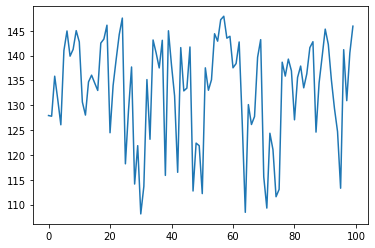

In [32]:
plt.plot(gdata.flatten()[100:200])